# Business Planning

Contextualização:
- A Rossmann é uma das maiores redes de farmácias da Europa, possuindo mais de 4.000 lojas, e 56 mil colaboradores até 2020.

Entendimento do negócio:

Qual o modelo de negócio?
- Varejo físico. A Rossmann é uma rede de farmácias com mais de 4.000 lojas, situadas em 7 países da Europa. Ela fabrica boa parte dos seus produtos, e os vende no varejo.

Qual é o problema de negócio?
- Em uma reunião mensal de resultados da Rossmann, o CFO solicitou aos gerentes das lojas a **previsão de vendas (faturamento) para as próximas 6 semanas**, pois ele precisa saber quanto cada loja pode contribuir financeiramente para uma reforma na rede, que está padronizando suas lojas.

Planejamento da solução:

[Saída]

- Produto final (O que vou entregar?): Relatório que informe por loja, qual sua a previsão de vendas (€) para as próximas 6 semanas.
- Formato da entrega: protótipo: https://docs.google.com/spreadsheets/d/1_LKT5vWN0KoR2cQtfOHN9g63l1wHrCk49pb_rP3i5XA/edit#gid=0
- Local da entrega: Deve ser acessível via mobile: Boot para telegram.


[Processo] 
- Quais os passos para entregar o produto final?
 - Planejamento da solução; OK
 - Compreender com clareza o modelo e o problema de negócios, através da estatística descritiva;
 - Tratar os dados (formatos, dados faltantes, outliers), realizando a sua limpeza.
 - Levantar junto ao time de negócio as variáveis que impactam nas vendas, formular e validar hipóteses gerando insights de negócio, e perceber quais variáveis são insumos relevantes para o algoritmo de previsão de vendas.
 - Preparar os dados para a criação do modelo de previsão de vendas, realizando transformações, separação do dataframe entre treino e teste, e seleção de features através de algoritmo com esta finalidade.
 - Treinar 5 algoritmos de aprendizado de máquina (lineares e não lineares), comparar sua performance, e selecionar o que melhor desempenha.
 - Encontrar o conjunto de parâmetros que maximiza o aprendizado do modelo selecionado, reduzindo o seu erro nas previsões.
 - Interpretar o erro do modelo e traduzir em resultado financeiro para a empresa.
 - Avaliar se a previsão de vendas construída já entrega valor ao time de negócios, publicando em produção em caso positivo, ou realizando um novo ciclo de melhorias pontuais em caso negativo.
 - Após a publicação, criar robô no Telegram que acesse a previsão em tempo real, de qualquer lugar.
 - Apresentar e disponibilizar o bot do Telegram aos gerentes e CFO, detalhando o funcionamento do modelo e esclarecendo as suas dúvidas.

- Granularidade: Previsão de vendas por loja em euro, para as próximas 6 semanas (42 dias). 
- Tipo de problema: Previsão de vendas.
- Potenciais métodos: Séries temporais e regressão. 
 
[Entrada]

Fontes de dados, Questões a responder, Problema de negócio
- Dataset Rossmann no Kaggle.

Ferramentas
- Python 3.8, Jupyter Notebook, Git, Github

# Imports + Helper Funcions

## Imports

In [1]:
import inflection
import math
import random
import pickle
import pandas                      as pd 
import seaborn                     as sns
import numpy                       as np
import datetime                    as dt
import sweetviz                    as sv
import xgboost                     as xgb
from matplotlib                    import pyplot as plt
from matplotlib.ticker             import FuncFormatter
from IPython.core.display          import HTML
from tabulate                      import tabulate
from IPython.display               import Image
from sklearn.preprocessing         import MinMaxScaler, LabelEncoder
from sklearn.feature_selection     import SelectFromModel, SelectPercentile, f_regression
from sklearn.ensemble              import RandomForestRegressor
from sklearn.metrics               import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model          import LinearRegression

## Helper Functions

In [2]:
def jupyter_settings():
    """ Otimiza configurações gerais, padronizanod tamanhos de plots, etc """
    %matplotlib inline
    #%pylab inline - not recommended
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 35)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def ml_error( model_name, y, yhat ):
    """ Calcula os erros do modelo recebido 
    model_name: nome do modelo
             y: valores de vendas reais
          yhat: valores de vendas estimados pelo modelo """
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse  }, index=[0] )

#Apenas para tarefas envolvendo time series, em função do kfold.
def cross_validation( x_training, kfold , model_name, model, verbose=False):
    """ Calcula e retorna a performance real de um modelo, com métricas de erros 'MAE','MAPE','RMSE', no formato (erro ± 1 std)
            x_training: daset_treino 
            kfold: número de divisões
            model_name: nome do modelo
            model: modelo já instanciado
            verbose: True para exibir os logs
    """
    
    mae_list = []
    mape_list = []
    rmse_list = []

    k = 1
    for k in reversed (range(1,kfold+1) ):
        #calcula datas iniciais e finais treino e validação para cada iteração. Ativar modo verbose para detalhes.
        validation_start_date = x_training['date'].max() - dt.timedelta( days=k*6*7 ) 
        validation_end_date = x_training['date'].max() - dt.timedelta( days=(k-1)*6*7 )

        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date) ]

        if verbose: 
            print('\nKFold Number: ',k)
            print('kFold training start date: ',training['date'].min() )
            print('kFold training end date: ',training['date'].max() )
            print('kFold validation start date: ',validation_start_date)
            print('kFold validation end date: ',validation_end_date)
            
        #training and validation dataset:
        # vou excluir agora as colunas date e sales para treino e validação:  
        xtraining = training.drop( ['date','sales'], axis=1 )#features
        ytraining = training['sales']#variável resposta            
        xvalidation = validation.drop( ['date','sales'], axis=1 ) #features
        yvalidation = validation['sales']#variável resposta

        #model training (sobre os dados de treino)
        m = model.fit( xtraining, ytraining )

        #model prediction (sobre os dados de validação)
        yhat = m.predict ( xvalidation )

        #performance
        m_result = ml_error ( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        #store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] ) 

    #cria dicionário calculando a média e std de cada erro, 
    #e já retorna um df pronto com a performance do modelo no formato: (erro ± 1 std):
    return pd.DataFrame ( {
        'Model Nme': model_name,
        'MAE CV': np.round(np.mean( mae_list),2 ).astype( str ) + ' ± ' + np.round(np.std( mae_list),2 ).astype( str ),
        'MAPE CV': np.round(np.mean( mape_list),2 ).astype( str ) + ' ± ' + np.round(np.std( mape_list),2 ).astype( str ),
        'RMSE CV': np.round(np.mean( rmse_list),2 ).astype( str ) + ' ± ' + np.round(np.std( rmse_list),2 ).astype( str ) }, index=[0] )


## Loading Data

In [101]:
# join sales and stores raw data
df_sales_raw = pd.read_csv("../data/train.csv", low_memory=False,  parse_dates=['Date'])# lê todo o arquivo de uma vez 
df_store_raw = pd.read_csv("../data/store.csv", low_memory=False)
# merge
df_raw = pd.merge(  df_sales_raw, df_store_raw, how='left', on='Store' ) 

In [102]:
df_raw.sample(5) 
# granularidade: Sales contém valores de vendas por dia e por loja

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
359317,541,5,2014-08-22,5974,885,1,1,0,0,a,c,650.0,7.0,1990.0,0,NaN,NaN,NaN
627821,862,1,2013-12-16,19498,1987,1,1,0,0,a,c,2840.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
935975,161,4,2013-03-14,5605,738,1,0,0,0,a,c,2970.0,3.0,2005.0,0,NaN,NaN,NaN
115064,220,7,2015-04-19,0,0,0,0,0,0,a,a,1000.0,9.0,2008.0,0,NaN,NaN,NaN
742230,426,3,2013-09-04,4125,650,1,0,0,0,a,a,250.0,NaN,NaN,0,NaN,NaN,NaN


In [125]:
#export to CSV:
df_raw.to_csv('../data/1_df_raw.csv', index=False) #index=False if I have first columns as index, avoids saving with the unnamed:0.

# Passo 1 - Data Description

In [189]:
df_desc = pd.read_csv('../data/1_df_raw.csv', low_memory=False, parse_dates=['Date'])
#df_desc = df_raw.copy()

## Rename Columns

In [190]:
df_desc.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [191]:
#pega as colunas originais
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
#cria função pra transformar em snake_case
snakecase = lambda x: inflection.underscore ( x )
#aplica a função em todas as palabras de cols_old, guarda em lista na cols_new
cols_new = list( map( snakecase, cols_old ) )
#rename
df_desc.columns = cols_new
df_desc.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [192]:
#renomeando para que os nomes façam mais sentido, evitando interpretações erradas:
df_desc = df_desc.rename(columns={
                        'promo': 'promo_today',
                        'promo2': 'promo_ext',
                        'promo2_since_week': 'promo_ext_init_week',
                        'promo2_since_year': 'promo_ext_init_year',
                        'promo_interval':'promo_ext_init_months',
                        'competition_distance': 'compet_distance',
                        'competition_open_since_month': 'compet_init_month',
                        'competition_open_since_year':'compet_init_year'
                        })
df_desc.head(3)

,store,day_of_week,date,sales,customers,open,promo_today,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [193]:
#reordenando colunas
df_desc.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open',
       'promo_today', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'compet_distance', 'compet_init_month',
       'compet_init_year', 'promo_ext', 'promo_ext_init_week',
       'promo_ext_init_year', 'promo_ext_init_months'],
      dtype='object')

In [194]:
df_desc = df_desc[['store', 'day_of_week', 'date', 'sales', 'customers', 'open',
       'state_holiday', 'school_holiday', 'store_type', 'assortment', 
        'compet_distance', 'compet_init_month', 'compet_init_year', 
        'promo_today', 'promo_ext', 'promo_ext_init_week', 'promo_ext_init_year', 'promo_ext_init_months']]

In [195]:
df_desc.head(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,1,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## Columns Meanings

In [210]:
# Entender o que significa o dado de cada coluna é fundamental para avançar no projeto!
tab = [['Coluna', 'Significado'],
    #####################################################     
       ['store', 'id único de cada loja'],
       ['day_of_week', 'indica o dia da semana'],
       ['date', 'data do registro'],
       ['sales', 'faturamento ($) da loja naquele dia'],
       ['customers', 'número de clientes na loja naquele dia'],
       ['open', 'loja aberta ou fechada: (0 = closed, 1 = open)'],
       ['state_holiday', 'feriado nacional (a = public holiday, b = Easter holiday, c = Christmas, 0 = Dia Comum)'],
       ['school_holiday', 'indica se a loja naquele dia foi afetada pelo fechamento das escolas púclicas'],
       ['store_type', 'indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)'],
       ['assortment', 'indica o nível de sortimento da loja: (a = basic, b = extra, c = extended)'],
       ['compet_distance', 'indica a distancia em metros do competidor mais próximo'],
       ['compet_init_month', 'indica mês aproximado da abertura do competidor mais próximo'],
       ['compet_init_year', 'indica ano aproximado da abertura do competidor mais próximo'],
       ['promo_today', 'indica se a loja está com uma promoção ativa naquele dia'],
       ['promo_ext', 'é uma promoção contínua e consecutiva: (0 = store not participating, 1 = store participating)'],
       ['promo_ext_init_week', 'indica a semana do calendário onde a loja entrou em promo_ext'],
       ['promo_ext_init_year' , 'indica o ano onde a loja entrou em promo_ext'],
       ['promo_ext_init_months', 'indica os meses de início anual onde promo_ext é iniciada (ex: "Feb,May,Aug,Nov")']
      ]
print(tabulate(tab, headers='firstrow', stralign='left')) #tablefmt='pipe', tablefmt='grid'

Coluna                 Significado
---------------------  ---------------------------------------------------------------------------------------------
store                  id único de cada loja
day_of_week            indica o dia da semana
date                   data do registro
sales                  faturamento ($) da loja naquele dia
customers              número de clientes na loja naquele dia
open                   loja aberta ou fechada: (0 = closed, 1 = open)
state_holiday          feriado nacional (a = public holiday, b = Easter holiday, c = Christmas, 0 = Dia Comum)
school_holiday         indica se a loja naquele dia foi afetada pelo fechamento das escolas púclicas
store_type             indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)
assortment             indica o nível de sortimento da loja: (a = basic, b = extra, c = extended)
compet_distance        indica a distancia em metros do competidor mais próximo
compet_init_month      indica mês aproximado da aber

## Data Dimension

In [197]:
print (f'Number of rows: {df_desc.shape[0] }')
print (f'Number of columns: {df_desc.shape[1] }')

Number of rows: 1017209
Number of columns: 18


## Data Types

In [198]:
df_desc.dtypes

store                             int64
day_of_week                       int64
date                     datetime64[ns]
sales                             int64
customers                         int64
open                              int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
compet_distance                 float64
compet_init_month               float64
compet_init_year                float64
promo_today                       int64
promo_ext                         int64
promo_ext_init_week             float64
promo_ext_init_year             float64
promo_ext_init_months            object
dtype: object

## Check NA

In [199]:
# Ver todas linhas que tem ao menos 1 NA
df_desc.isna().sum()

store                         0
day_of_week                   0
date                          0
sales                         0
customers                     0
open                          0
state_holiday                 0
school_holiday                0
store_type                    0
assortment                    0
compet_distance            2642
compet_init_month        323348
compet_init_year         323348
promo_today                   0
promo_ext                     0
promo_ext_init_week      508031
promo_ext_init_year      508031
promo_ext_init_months    508031
dtype: int64

### Algumas formas de tratar NAs:
1 - Excluir todas as linhas com NA.
     - Bom: rápido e fácil
     - Péssimo: descarta dados, pode prejudicar meu modelo.
    
2 - Usar algoritmos de ML pra substituir NAs pela média, mediana, prevendo o número que seria 
através das colunas que tem valor.

3 - Descobrir porque o NA tá aqui. Pode ter trocado o sistema, antes não tinha essa coluna. Ou ainda antes era o valor de outra coluna.

## Fillout NA

In [14]:
# Vamos tratar caso a caso, para cada 1 das 6 colunas com NAs:

In [203]:
df_desc.sample(1)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
936510,696,4,2013-03-14,6305,861,1,0,1,a,c,430.0,NaN,NaN,0,0,NaN,NaN,NaN


In [202]:
# Caso 1 - compet_distance: indica a distancia em metros do competidor mais próximo

# Vou assumir que os que não tem valor aqui, não tem competidores perto.
# Logo, vou atribuir pros NAs um valor bem maior que o maior valor de distância existente.

# Maior distância existente
print(df_desc['compet_distance'].max())
# Atribuir o valor pra todas NA
df_desc['compet_distance'] = df_desc['compet_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x ) 

75860.0


In [205]:
# Caso 2 - compet_init_month: indica o mês aproximado da abertura do competidor mais próximo
# Se esta coluna está vazia, ou deve ser porque não tem competidor próximo, ou porque não sabem quando foi aberta. 

# Verificar se os NAs são sempre das mesmas lojas
df_desc.loc[df_desc['compet_init_month'].isna() ].head(5)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
11,12,5,2015-07-31,8959,962,1,0,1,a,c,1070.0,NaN,NaN,1,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,0,0,d,a,310.0,NaN,NaN,1,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,5,2015-07-31,10231,979,1,0,1,a,c,3270.0,NaN,NaN,1,0,NaN,NaN,NaN
18,19,5,2015-07-31,8234,718,1,0,1,a,c,3240.0,NaN,NaN,1,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,5,2015-07-31,6566,633,1,0,0,a,a,1040.0,NaN,NaN,1,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [166]:
# Conferir lojas 12, 13, 16, 19, 22, 1096.. todas tem NAs pra todos registros.
df_desc.loc[df_desc['store'] == 1096 ].sample(5)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
987085,1096,1,2013-01-28,3168,462,1,0,0,a,c,1130.0,NaN,NaN,0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
217405,1096,7,2015-01-18,0,0,0,0,0,a,c,1130.0,NaN,NaN,0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
282179,1096,4,2014-11-13,5453,640,1,0,0,a,c,1130.0,NaN,NaN,1,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
424010,1096,2,2014-06-17,6591,720,1,0,0,a,c,1130.0,NaN,NaN,1,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
604640,1096,1,2014-01-06,9912,943,1,0,1,a,c,1130.0,NaN,NaN,1,1,10.0,2014.0,"Mar,Jun,Sept,Dec"


In [206]:
# Neste caso, vou assumir nesse primeiro ciclo a data de venda (date) como a data de abertura do competidor, mesmo que seja simplista.
# precisa axis aqui, pois são duas colunas que estamos mexendo no lambda
df_desc['compet_init_month'] = df_desc.apply ( lambda x: x['date'].month 
                    if math.isnan( x['compet_init_month'] ) 
                    else x['compet_init_month'], axis=1 ) 

In [209]:
# Caso 3 - compet_init_year: indica ano aproximado da abertura do competidor mais próximo

# Vamos fazer pro year o mesno que o feito pro month:
df_desc['compet_init_year'] = df_desc.apply ( lambda x: x['date'].year 
                    if math.isnan( x['compet_init_year'] ) 
                    else x['compet_init_year'], axis=1 ) 

In [217]:
# Caso 4 - promo_ext_init_week: indica a semana do calendário onde a loja entrou em promo_ext
#            promo_ext: é uma promoção contínua e consecutiva: (0 = store not participating, 1 = store participating)

# Também vamos seguir a mesma lógica por hora, setando a partir da data de venda
df_desc['promo_ext_init_week'] = df_desc.apply ( lambda x: x['date'].week 
                    if math.isnan( x['promo_ext_init_week'] ) 
                    else x['promo_ext_init_week'], axis=1 )

In [211]:
# Caso 5 - promo_ext_init_year: indica o ano onde a loja entrou em promo_ext

# Também vamos seguir a mesma lógica por hora, setando a partir da data de venda
df_desc['promo_ext_init_year'] = df_desc.apply ( lambda x: x['date'].year 
                    if math.isnan( x['promo_ext_init_year'] ) 
                    else x['promo_ext_init_year'], axis=1 )

In [218]:
df_desc.head(5)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,1,0,31.0,2015.0,NaN
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,1,0,31.0,2015.0,NaN
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,1,0,31.0,2015.0,NaN


In [219]:
# Caso 6 - promo_ext_init_months: indica os meses de início anual onde promo_ext é iniciada (ex: "Feb,May,Aug,Nov")
# pra remover o NA daqui, vamos preencher NA com zeros
df_desc['promo_ext_init_months'].fillna(0, inplace=True)

In [221]:
df_desc.head(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,1,0,31.0,2015.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [222]:
#resolvido
df_desc.isna().sum()

store                    0
day_of_week              0
date                     0
sales                    0
customers                0
open                     0
state_holiday            0
school_holiday           0
store_type               0
assortment               0
compet_distance          0
compet_init_month        0
compet_init_year         0
promo_today              0
promo_ext                0
promo_ext_init_week      0
promo_ext_init_year      0
promo_ext_init_months    0
dtype: int64

## Change Types

In [223]:
# Como fizemos alteração nas colunas, é importante conferir se não mudou o formato dos dados
df_desc.dtypes

store                             int64
day_of_week                       int64
date                     datetime64[ns]
sales                             int64
customers                         int64
open                              int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
compet_distance                 float64
compet_init_month               float64
compet_init_year                float64
promo_today                       int64
promo_ext                         int64
promo_ext_init_week             float64
promo_ext_init_year             float64
promo_ext_init_months            object
dtype: object

In [224]:
#converter de float pra int64
df_desc['compet_distance'] = df_desc['compet_distance'].astype( np.int64 )
df_desc['compet_init_month'] = df_desc['compet_init_month'].astype( np.int64 )
df_desc['compet_init_year'] = df_desc['compet_init_year'].astype( np.int64 )
df_desc['promo_ext_init_week'] = df_desc['promo_ext_init_week'].astype( np.int64 )
df_desc['promo_ext_init_year'] = df_desc['promo_ext_init_year'].astype( np.int64 )

In [225]:
#ok!
df_desc.dtypes

store                             int64
day_of_week                       int64
date                     datetime64[ns]
sales                             int64
customers                         int64
open                              int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
compet_distance                   int64
compet_init_month                 int64
compet_init_year                  int64
promo_today                       int64
promo_ext                         int64
promo_ext_init_week               int64
promo_ext_init_year               int64
promo_ext_init_months            object
dtype: object

In [226]:
df_desc.sample(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
931201,962,2,2013-03-19,8534,1118,1,0,0,c,a,260,3,2013,1,0,12,2013,0
151539,1015,3,2015-03-18,5939,447,1,0,0,d,c,9910,12,2010,1,1,9,2011,"Mar,Jun,Sept,Dec"
47398,569,5,2015-06-19,4719,667,1,0,0,a,a,1340,9,2006,1,0,25,2015,0


## Descriptive Statistical

Serve para 2 coisas:
 - 1  Termos alguma noção de negócios pelos dados
 - 2  Conseguirmos detectar alguns erros (venda negativa por ex..)

Métricas de tendência central: média e mediana (resumem dados em um único número)

Metricas de dispersão: desvio padrão, min, max, range, skew, kurtosis

In [227]:
#separa variáveis numéricas e categóricas, pra aplicar a estatística em cada conjunto:
num_attributes = df_desc.select_dtypes ( include=['int64','float64'] )
cat_attributes = df_desc.select_dtypes ( exclude=['int64','float64','datetime64[ns]'] )

In [228]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,school_holiday,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year
290380,846,2,13097,1055,1,0,8860,4,2004,1,1,37,2009
771122,328,5,4105,519,1,1,3130,7,2002,0,0,32,2013
563875,471,2,5325,502,1,0,5300,2,2014,0,1,45,2009
252277,3,7,0,0,0,0,14130,12,2006,0,1,14,2011
405802,232,4,3952,347,1,0,13570,5,2010,1,1,10,2013


In [229]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_ext_init_months
282572,0,c,a,"Mar,Jun,Sept,Dec"
215273,0,a,a,0
632414,0,d,a,0
783323,0,a,a,0
790582,0,d,c,"Mar,Jun,Sept,Dec"


### Numerical Attibures

In [230]:
#Métricas de tendência central: média e mediana
ct1 = pd.DataFrame ( num_attributes.apply ( np.mean ) ).T
ct2 = pd.DataFrame ( num_attributes.apply ( np.median ) ).T

#Metricas de dispersão (variabilidade): desvio padrão, min, max, range, skew, kurtosis
di1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
di2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
di3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
di4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
di5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
di6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#concatenate
desc_stat = pd.concat( [di2, di3, di4, ct1, ct2, di1, di5, di6 ] ).T.reset_index() 
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [231]:
#Análise geral de features numéricas:
desc_stat

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
6,compet_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
7,compet_init_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
8,compet_init_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304
9,promo_today,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018


Análise de Sales (var target):

- Mediana (concentração de valores) levemetente abaixo que média. 
- Logo, distribuição próxima de uma normal, levemente deslocada para esquerda, vide skew levemente positiva. 
- Kurtosis positiva próxima a 2, indicando a existência de valores extremos, mas sem tanta intensidade.
- A média é de 5773 vendas/dia, e o std de 3850: Isto significa que em 68% dos dias (±1 std), temos entre 1923 (5773-3850) e 9.623 (5773+3850) vendas.

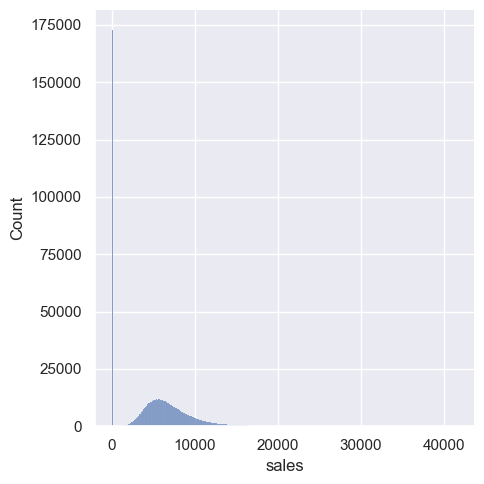

In [232]:
#Anlálise de SALES (variável dependente)
p = sns.displot ( df_desc['sales'] )
p.fig.set_dpi(100)
plt.show()

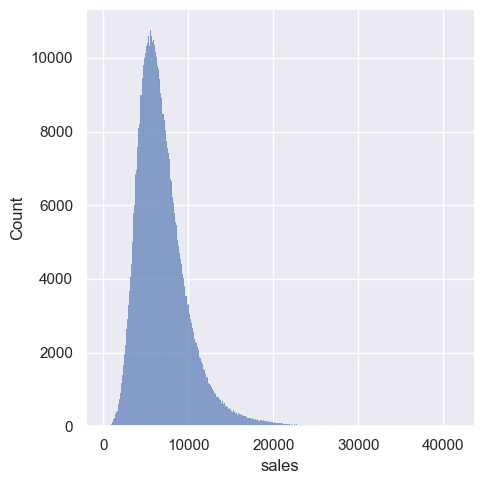

In [233]:
#Vou retirar agora as vendas = 0 pra analisar apenas quando houve faturamento:
df_sales_pos = df_desc.loc[ df_desc['sales'] > 0 ]
p = sns.displot ( df_sales_pos['sales'] )
plt.show()

### Categorical Attibures

In [234]:
#número de variações de cada coluna:
cat_attributes.apply ( lambda x: x.unique().shape[0] )

state_holiday            4
store_type               4
assortment               3
promo_ext_init_months    4
dtype: int64

In [235]:
#distribuição de state_holiday
df_desc['state_holiday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: state_holiday, dtype: int64

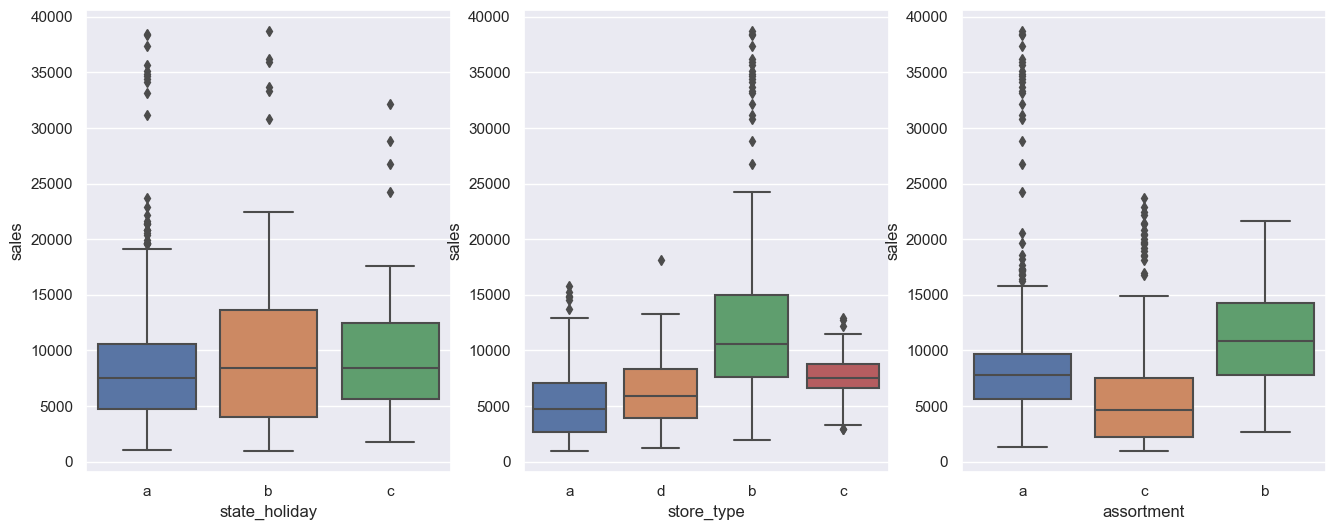

In [236]:
#Boxplot tem todas as medidas de dispersão e tendência central. Vamos usá-lo.

#vendas nos feriados: remover dias não feriado, e dias onde não teve vendas.
aux_cat = df_desc[ (df_desc['state_holiday'] != '0') & (df_desc['sales'] > 0) ]

#setar tamanho:
sns.set(rc={'figure.figsize':(16,6)})

plt.subplot (1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux_cat );

plt.subplot (1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux_cat );

plt.subplot (1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux_cat );

- Acima, a linha meio de cada boxplot é o 50º quartil, ou seja a mediana.
- A borda de baixo do boxplot é o quartil 25, a de cima o 75.
- Logo, dentro do boxplot, temos o volume do quartil 25 ao 50, e do 50 ao 75. Sendo assim, dentro do boxplot temos 50% dos dados. 
- Fora do boxplot, os traços horizontais superiores e inferiores são os valor mínimos e máximos dos dados.
- Pontos após os traços horizontais (valores máximos), temos os outliers, sendo > 3 vezes o desvio padrão.

- Assim, quanto mais achatada é a figura, maior a concentração em torno da mediana.

Análise do boxplot 1: quantidade de vendas por tipo de feriado:

- Legenda de state_holiday:
 - a = public holiday
 - b = Easter holiday
 - c = Christmas
- A mediana de vendas de páscoa(b) e natal (c) é mais alta que de feriados publicos (a).
- A mediana de vendas de páscoa(b) e natal (c) é parecida, mas a dispersão é maior na páscoa.

Análise do boxplot 2: quantidade de vendas por tipo de loja:
- Legenda de StoreType, com tipo de loja sendo:
 - a
 - b
 - c
 - d   
- Loja tipo b vende muito mais na mediana que as demais, aprox. o dobro da tipo a.
- Loja do tipo c tem concentração de vendas maior em torno da mediana.

Análise do boxplot 3: quantidade de vendas por mix de produtos:
- Legenda de Assortment: 
 - a = basic
 - b = extra
 - c = extended      
- Há muito mais vendas do mix b do que dos demais. E o número de vendas varia mais também
neste mix.
- O mix A tem uma grande quantidade de outliers, mas uma distribuição bem uniforme fora isto.

In [237]:
#export to CSV:
df_desc.to_csv('../data/2_data_description_done.csv', index=False)

# Passo 2 - Feature Engeneering

In [280]:
df_feat = pd.read_csv('../data/2_data_description_done.csv', low_memory=False, parse_dates=['date'])
#df_feat2 = df_desc.copy()

## Mindmap de Hipóteses

Agora, vamos criar o mindmap de hipóteses: levantar com área de negócios o que pode interferir no fenômeno de vendas. 

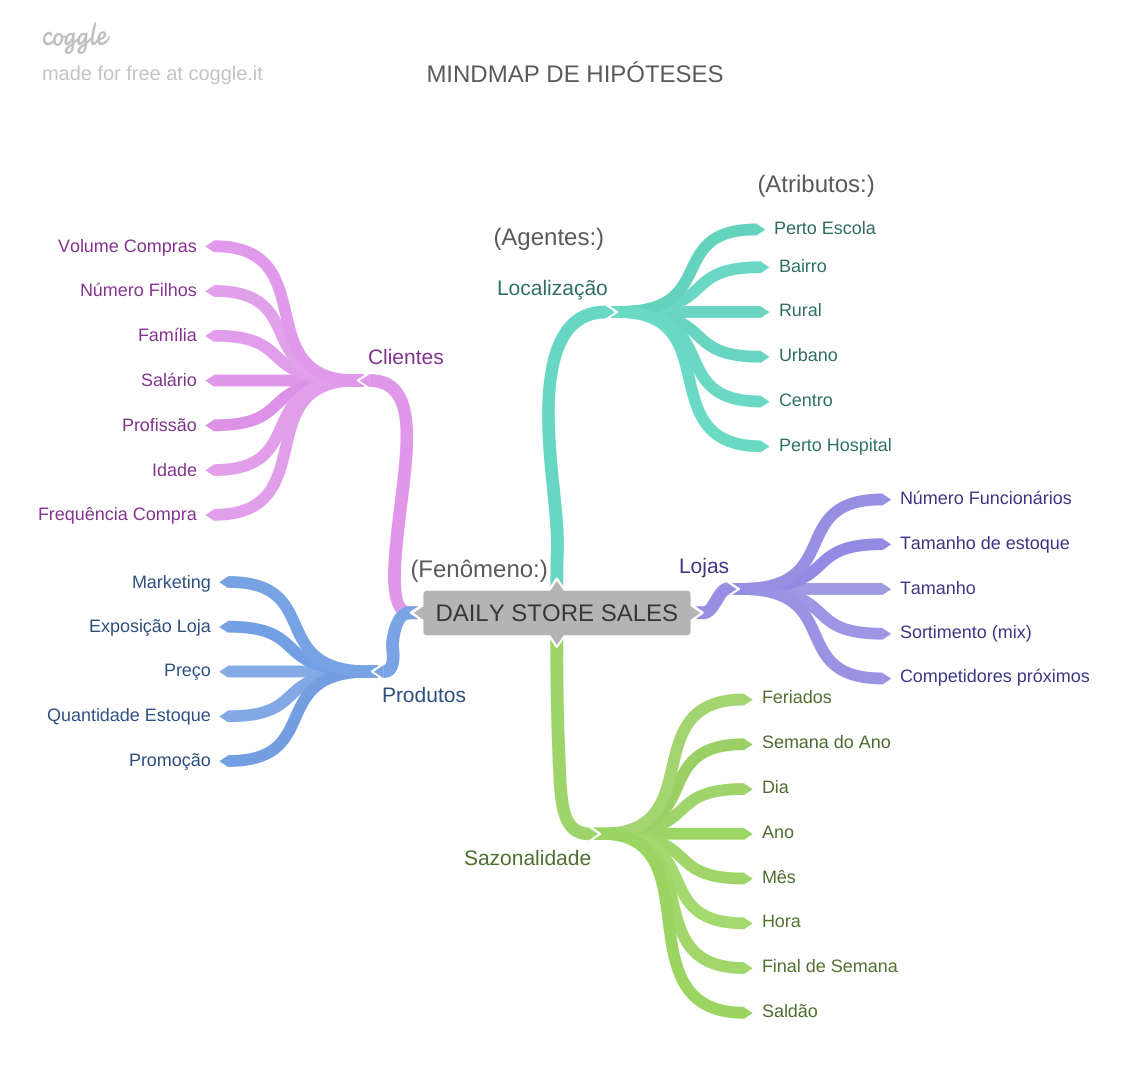

In [241]:
# Mindmap de hipótestes
Image ('../img/MindMapHypothesis.png')

## Criação das Hipóteses

Hipóteses são apostas que vou validar. Uma hipótese:
- É uma afirmação,
- Compara 2 variáveis,
 - Ex: H1-Loja: Lojas com maior sortimento devem vender mais.
 - Lembrando que correlação não implica causalidade: são apostas, mas necessariamente relações de causa e efeito.

Exemplos nesse contexto são:
- Lojas de MAIOR porte (atributo) deveriam vender (fenômeno) MAIS.
- Lojas com MAIOR sortimento (atributo) deveriam vender (fenômeno) MAIS.
- Lojas com MAIS competidores por perto (atributo) deveriam vender (fenômeno) MENOS.

Abaixo, criaremos algumas hipóteses para cada agente:

### Hipóteses Loja

#### Lojas com maior quadro de funcionários deveriam vender mais.

#### Lojas com maior estoque deveriam vender mais.

#### Lojas com maior porte deveriam vender mais.

#### Lojas com maior sortimento deveriam vender mais.

#### Lojas com competidores mais próximos deveriam vender menos.


#### Lojas com competidores à mais tempo deveriam vender mais.

### Hipóteses Produto

#### Lojas que investem mais em marketing deveriam vender mais.

#### Lojas com maior exposição de produto nas vitrines deveriam vender mais.

#### Lojas com produtos de preço menor deveriam vender mais.

#### Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

#### Lojas com promoções ativas por mais tempo deveriam vender mais.

#### Lojas com mais dias de promoção deveriam vender mais.

#### Lojas com mais promoções consecutivas deveriam vender mais.

### Hipóteses Sazonalidade

#### Lojas abertas duantes o feriado de natal deveriam vender mais.

#### Lojas deveriam vender mais ao longo dos anos.

#### Lojas deveriam vender no segundo semestre do ano.

#### Lojas deveriam vender mais no dia 10 de cada mês.

#### Lojas deveriam vender menos aos finais de semana.

#### Lojas deveriam vender menos durante os feriados escolares.

## Priorização das Hipóteses

Critérios: priorizar com negócio, buscando avançar nas hipóteses onde tenho o dado disponível neste ciclo!
- Se tenho, vou priorizar neste primeiro ciclo.
 - Cada hipótese vai gerar tabela, gráfico pra poder avaliar correlação com o fenômeno, como a força dessa correlação.
- Se não tenho, num ciclo futuro se necessário avalio coletar, conforme a performance do modelo.

Abaixo, estão as hipóteses priorizadas:

#### (H4 - prod) Lojas com promoções ativas por mais tempo deveriam vender mais.

#### (H9 - sazo) Lojas deveriam vender mais no segundo semestre do ano.

#### (H12 - sazo) Lojas deveriam vender menos durante os feriados escolares.

## Feature Engeneering

Ajustar também categorias, facilitando a EDA:
- 1 - assortment: trocar letras a b e c pelo mix de produtos por extenso.
- 2 - state_holiday: trocar letras a b c pelo nome por extenso.

Vou criar ainda uma nova feature que pode ajudar o modelo, visto que 'promo_ext_init_months' tem muitos zeros inseridos, e não parece ajudar muito no formato atual, como por exemplo: 'Jan,Apr,Jul,Oct':
- 3 - Criar 'promo_ext_today': indica se estava ou não em promoção extendida no dia da venda.

In [243]:
df_feat.sample(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
57640,776,3,2015-06-10,3870,445,1,0,0,c,a,700,4,2009,0,1,14,2011,"Jan,Apr,Jul,Oct"
165994,975,4,2015-03-05,8723,881,1,0,0,a,c,9630,3,2015,1,1,14,2011,"Jan,Apr,Jul,Oct"
555814,215,2,2014-02-18,7196,530,1,0,0,d,a,150,2,2014,1,1,45,2009,"Feb,May,Aug,Nov"


### assortment

In [281]:
#3 assortment: trocar letras a b e c pelo mix de produtos por extenso.
    #Assortment - describes an assortment level: a = basic, b = extra, c = extended
df_feat['assortment'] = df_feat['assortment'].apply ( lambda x: 
                               'basic' if x == 'a' else
                               'extra' if x == 'b' else 
                            'extended' if x == 'c' else x) 

In [282]:
#ok
df_feat['assortment'].value_counts()

basic       537445
extended    471470
extra         8294
Name: assortment, dtype: int64

### state_holiday

In [283]:
#4 state_holiday: trocar letras a b c pelo nome por extenso.
    #StateHoliday - indicates a state holiday. Normally all stores, with few exceptions,       #are closed on state holidays. Note that all schools are closed on public holidays and 
    #weekends. a = public holiday, b = easter_holiday, c = christmas, 0 = None
df_feat['state_holiday'] = df_feat['state_holiday'].apply ( lambda x: 
                                            'public_holiday' if x == 'a' else
                                            'easter_holiday' if x == 'b' else
                                                 'christmas' if x == 'c' else 
                                               'regular_day' )

In [284]:
#ok
df_feat['state_holiday'].value_counts()

regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

In [285]:
df_feat.sample(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months
294112,837,5,2014-10-31,5190,692,1,regular_day,1,a,extended,14600,4,2015,0,0,44,2014,0
772432,523,4,2013-08-08,15661,1960,1,regular_day,0,c,extended,50,11,2013,0,0,32,2013,0
230264,575,2,2015-01-06,0,0,0,public_holiday,0,a,basic,960,5,2008,1,1,13,2010,"Jan,Apr,Jul,Oct"


### promo_ext_init_months

In [286]:
#Vou criar ainda uma nova feature que pode ajudar o modelo, visto que 'promo_ext_init_months' tem muitos zeros inseridos, e não parece ajudar muito no formato atual, como por exemplo: 'Jan,Apr,Jul,Oct':
#- 3 - Criar 'promo_ext_today': indica se estava ou não em promoção extendida no dia da venda.

# criar variável auxiliar 'month_sale_map' setando o mes da venda nela
month_sale_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',  9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df_feat['month_sale_map'] = df_feat['date'].dt.month.map( month_sale_map )

In [287]:
df_feat.sample(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months,month_sale_map
996511,487,6,2013-01-19,6857,701,1,regular_day,0,d,extended,2180,9,2012,0,1,40,2012,"Jan,Apr,Jul,Oct",Jan
441241,487,7,2014-06-01,0,0,0,regular_day,0,d,extended,2180,9,2012,0,1,40,2012,"Jan,Apr,Jul,Oct",Jun
18335,496,3,2015-07-15,9202,872,1,regular_day,0,d,extended,2780,6,2015,1,0,29,2015,0,Jul


In [288]:
# Agrora, 'promo_ext_today' recebe 1, se 'month_sale_map' (mês da venda) estiver em 'promo_ext_init_months', senão 0.
    # Ex: 'month_sale_map'='Nov', 'promo_ext_init_months'='Feb,May,Aug,Nov', logo 'promo_ext_today' = 1, pois estava em promoção estendida no mês da venda.
    # Naturalmente, se 'promo_ext_init_months' for zero, 'promo_ext_today' será 0 também, pois não temos info sobre os meses onde a campanha recorrente acontecia.
df_feat['promo_ext_today'] = df_feat[['promo_ext_init_months', 'month_sale_map']].apply ( lambda x: 
      0 if x['promo_ext_init_months'] == 0 else 
      1 if x['month_sale_map'] in x['promo_ext_init_months'].split(',') else 0, axis =1 )

In [289]:
df_feat.sample(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months,month_sale_map,promo_ext_today
649616,357,2,2013-11-26,6653,909,1,regular_day,0,a,basic,2060,10,2008,0,0,48,2013,0,Nov,0
74702,1113,2,2015-05-26,6757,716,1,regular_day,0,a,extended,9260,5,2015,0,0,22,2015,0,May,0
406555,6,3,2014-07-02,6288,684,1,regular_day,0,a,basic,310,12,2013,1,0,27,2014,0,Jul,0


In [290]:
#Save CSV:
df_feat.to_csv('../data/3_feature_eng_done.csv', index=False)

# Passo 3 -  Filtragem de Variáveis

In [301]:
df_filt = pd.read_csv('../data/3_feature_eng_done.csv', low_memory=False, parse_dates=['date'])
#df_filt = df_feat.copy()

In [302]:
df_filt.sample(3)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months,month_sale_map,promo_ext_today
30828,724,6,2015-07-04,5568,519,1,regular_day,0,d,extended,5900,7,2015,0,0,27,2015,0,Jul,0
104354,660,3,2015-04-29,6274,633,1,regular_day,0,a,basic,1200,11,2006,1,1,40,2014,"Jan,Apr,Jul,Oct",Apr,1
883394,1100,3,2013-05-01,0,0,0,public_holiday,0,a,basic,540,5,2013,1,1,14,2011,"Jan,Apr,Jul,Oct",May,0


## Filtragem das Linhas

- 'open' == 0 -> vamos remover registros onde lojas estavam fechadas, pois é inútil p/ prever vendas.
- 'sales' == 0 -> vamos remover também registros onde vendas = 0, pois também é inútil prever vendas quando não houve nenhuma no dia.

In [303]:
#registros onde loja está fechada:
df_filt.loc[ (df_filt['open'] == 0) ].size

3456340

In [304]:
#registros onde o faturamento é zero:
df_filt.loc[ (df_filt['sales'] == 0) ].shape[0]

172871

In [305]:
# manter só registros onde a loja estava aberta, e onde o valore de venda foi > zero:
df_filt = df_filt.loc[ (df_filt['open'] != 0) & (df_filt['sales'] > 0) ]

In [306]:
#após a filtragem de registros
df_filt.shape

(844338, 20)

## Filtragem das Colunas

In [307]:
df_filt.head(5)

,store,day_of_week,date,sales,customers,open,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_init_months,month_sale_map,promo_ext_today
0,1,5,2015-07-31,5263,555,1,regular_day,1,c,basic,1270,9,2008,1,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,regular_day,1,a,basic,570,11,2007,1,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,regular_day,1,a,basic,14130,12,2006,1,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,regular_day,1,c,extended,620,9,2009,1,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,regular_day,1,a,basic,29910,4,2015,1,0,31,2015,0,Jul,0


Colunas a remover:

customers
- Não adianta eu considerar clientes numa previsão de vendas, se não tenho a previsão de clientes. Não temos como prever os clientes futuros, a menos que façamos um projeto a parte.

open
- Pois todas que ficaram, tem valor = 1.

promo_ext_init_months
- Porque já derivei 'promo_ext_today' dela.

month_sale_map
'month_sale_map' pois foi uma var auxiliar.

In [308]:
#remover as colunas citadas 
cols_drop = ['customers', 'open', 'promo_ext_init_months', 'month_sale_map']
df_filt = df_filt.drop(cols_drop, axis=1) #axis=1 = colunas

In [311]:
df_filt.sample(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today
553108,854,5,2014-02-21,7491,regular_day,1,c,basic,4770,2,2014,1,1,13,2010,0
211750,1016,5,2015-01-23,3729,regular_day,0,c,extended,550,1,2015,0,1,35,2010,0
396146,976,1,2014-07-14,9667,regular_day,1,a,basic,4180,7,2014,1,0,29,2014,0


In [312]:
#Save CSV:
df_filt.to_csv('../data/4_variable_filtering_done.csv', index=False)

# Passo 4 - Análise Exploratória dos Dados

In [4]:
df_eda = pd.read_csv('../data/4_variable_filtering_done.csv', low_memory=False, parse_dates=['date'])
#df_eda = df_feat.copy()

In [5]:
df_eda.head(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today
0,1,5,2015-07-31,5263,regular_day,1,c,basic,1270,9,2008,1,0,31,2015,0
1,2,5,2015-07-31,6064,regular_day,1,a,basic,570,11,2007,1,1,13,2010,1
2,3,5,2015-07-31,8314,regular_day,1,a,basic,14130,12,2006,1,1,14,2011,1


## Análise Univariada com SweetViz

- Responde: Como se comporta cada variável?
- Vamos utilizar o SweetViz como ferramenta de apoio na análise univariada, detalhando visualmente cada feature, a variável resposta, e relação entre ambas.

In [6]:
# Gerar relatório com Sweet Viz
report = sv.analyze(df_eda, target_feat= "sales")
# Salvar e mostrar no navegador
report.show_html(filepath='../reports/sweetviz_report.html',open_browser=True)

C:\Users\norton.vanz\Anaconda3\envs\rossmann\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
C:\Users\norton.vanz\Anaconda3\envs\rossmann\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: sales (TARGET)                      |██▍                                      | [  6%]   00:00 -> (00:11 left)C:\Users\norton.vanz\Anaconda3\envs\rossmann\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
Feature: store    

Report ../reports/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
#Conferindo valores de day_of_week do relatório do Sweetviz
df_eda.day_of_week.value_counts()

6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: day_of_week, dtype: int64

In [9]:
df_eda[['sales','day_of_week']].groupby('day_of_week').mean().reset_index()

,day_of_week,sales
0,1,8216.252259
1,2,7088.409086
2,3,6728.786679
3,4,6768.214973
4,5,7073.034133
5,6,5875.084935
6,7,8224.723908


## Análise Bivariada

- Responde: Qual a força do impacto de uma variável na variável resposta?
- Vamos validar cada hipótese priorizada, e analisar se a variável é importante ou não para o modelo.

### (H4 - prod) Lojas com promoções ativas por mais tempo deveriam vender mais.

In [10]:
df_eda.sample(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today
47471,475,5,2015-06-12,5324,regular_day,0,a,basic,140,9,2005,0,0,24,2015,0
137703,562,3,2015-03-04,19001,regular_day,0,b,extended,1210,3,2015,1,0,10,2015,0
791458,446,2,2013-02-26,4096,regular_day,0,a,basic,340,10,2000,0,1,31,2013,1


In [11]:
# Criar primeiramente a feature 'promo_ext_active_weeks': tempo em que a promoção ficou ativa em semanas.
# Será a diferença em semanas entre a data da venda 'date' e 'promo_ext_init' criada abaixo, que calcula a data de início da promoção extendida. 
 
#1 criar 'promo_ext_init' Juntar colunas 'promo_ext_init_week' e 'promo_ext_init_year': 2012-48
df_eda['promo_ext_init'] = df_eda['promo_ext_init_year'].astype( str ) + '-' + df_eda['promo_ext_init_week'].astype( str )

In [12]:
#promo_ext_init: 2012-48
df_eda.tail(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init
844335,769,2,2013-01-01,5035,public_holiday,1,b,extra,840,1,2013,0,1,48,2012,1,2012-48
844336,948,2,2013-01-01,4491,public_holiday,1,b,extra,1430,1,2013,0,0,1,2013,0,2013-1
844337,1097,2,2013-01-01,5961,public_holiday,1,b,extra,720,3,2002,0,0,1,2013,0,2013-1


In [13]:
#2 converter esse string 2012-48 em data: ('%Y-%W-$w') -> (ano, semana do ano, inicia domingo):
df_eda['promo_ext_init'] = df_eda['promo_ext_init'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )

In [14]:
# promo_ext_init: 2012-11-19
df_eda.tail(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init
844335,769,2,2013-01-01,5035,public_holiday,1,b,extra,840,1,2013,0,1,48,2012,1,2012-11-19
844336,948,2,2013-01-01,4491,public_holiday,1,b,extra,1430,1,2013,0,0,1,2013,0,2012-12-31
844337,1097,2,2013-01-01,5961,public_holiday,1,b,extra,720,3,2002,0,0,1,2013,0,2012-12-31


In [15]:
#3 agora, subtrair 'date' - 'promo_ext_init', pra obter o tempo que a promoção ficou ativa ativa em semanas:
df_eda['promo_ext_active_weeks'] = ( ( df_eda['date'] - df_eda['promo_ext_init'] ) / 7).apply( lambda x: x.days ).astype(int)

In [16]:
#'promo_ext_init': 2012-11-19, 'date': '2013-01-01'  -> 'promo_ext_active_weeks': 6  #ok!
df_eda.tail(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks
844335,769,2,2013-01-01,5035,public_holiday,1,b,extra,840,1,2013,0,1,48,2012,1,2012-11-19,6
844336,948,2,2013-01-01,4491,public_holiday,1,b,extra,1430,1,2013,0,0,1,2013,0,2012-12-31,0
844337,1097,2,2013-01-01,5961,public_holiday,1,b,extra,720,3,2002,0,0,1,2013,0,2012-12-31,0


In [17]:
# Porém, há casos onde 'promo_ext_active_weeks' ficou negativo. Isto acontece porque a promoção extendida começou depois da data da venda:
df_eda.loc[df_eda['promo_ext_active_weeks'] < 0 ].sample(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks
730325,657,6,2013-05-04,4422,regular_day,0,c,extended,80,1,2006,0,1,10,2014,0,2014-03-03,-44
723726,815,1,2013-05-13,11626,regular_day,0,a,basic,590,1,1900,1,1,40,2014,0,2014-09-29,-72
710896,310,1,2013-05-27,11404,regular_day,0,a,extended,2290,5,2013,1,1,10,2014,0,2014-03-03,-40


In [18]:
# para tratar isto, vamos setar zero, sempre que 'promo_ext_active_weeks' for negativo:
df_eda.loc[df_eda['promo_ext_active_weeks'] < 0, 'promo_ext_active_weeks'] = 0 

In [19]:
# nenhum registro < 0 restante:
df_eda.loc[df_eda['promo_ext_active_weeks'] < 0]

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks


In [20]:
#feature 'promo_ext_active_weeks' ok
df_eda.sample(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks
101588,313,1,2015-04-13,11264,regular_day,0,d,extended,14160,4,2015,1,0,16,2015,0,2015-04-13,0
203393,878,6,2014-12-20,8637,regular_day,0,d,extended,1100,12,2014,0,0,51,2014,0,2014-12-15,0
603269,230,2,2013-09-17,5279,regular_day,0,d,extended,6680,9,2013,0,0,38,2013,0,2013-09-16,0


- (H4 - prod) Lojas com promoções ativas por mais tempo deveriam vender mais.
- 'promo_ext_active_weeks' = 0, indica que a venda não foi feita em período de promoção extendida, e > 0, indica que foi.

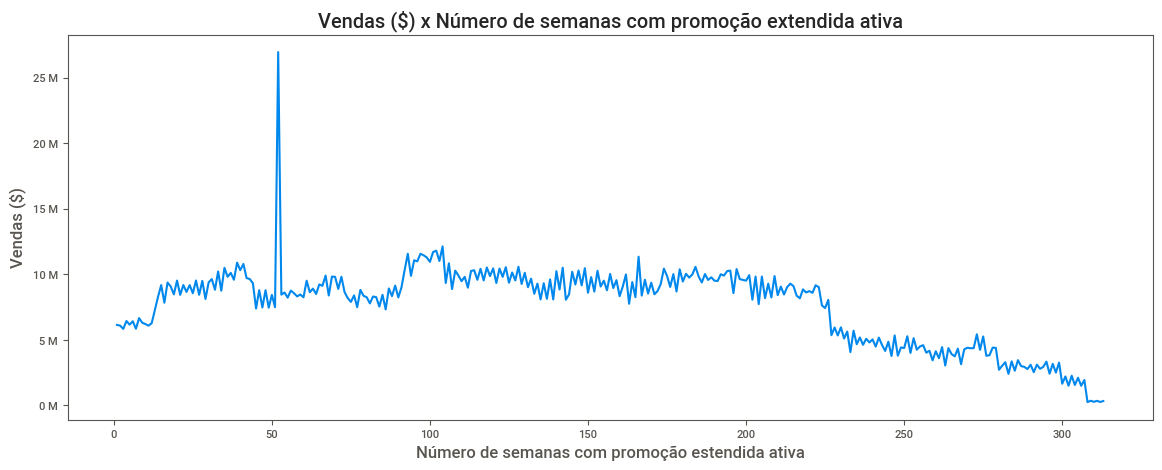

In [21]:
aux_h4 = df_eda[df_eda['promo_ext_active_weeks'] > 0] 
aux_h4_pos = aux_h4[['promo_ext_active_weeks', 'sales']].groupby ( 'promo_ext_active_weeks' ).sum().reset_index()

plt.rcParams["figure.figsize"] = (14, 5)
h4_line = sns.lineplot( x='promo_ext_active_weeks', y='sales', data=aux_h4_pos);
h4_line.set_title('Vendas ($) x Número de semanas com promoção extendida ativa');
h4_line.set_ylabel('Vendas ($)');
h4_line.set_xlabel('Número de semanas com promoção estendida ativa');
h4_line.ticklabel_format(style='plain', axis='y')  #remover scientific notation

ax = plt.gca() ##configurar grandeza numérica no eixo
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + ' M'))

- Alisando o gráfico superior, percebemos que as promoções extendidas das lojas venderam de forma estável por aprox. 3 trimestes, mas no quarto, as vendas cairam.
- Logo, a hipótese é **FALSA**: Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS.

### (H9 - sazo) Lojas deveriam vender mais no segundo semestre do ano.

In [22]:
# Criar primeiramente a feature 'month_sale', sendo o mês da venda.
df_eda['month_sale'] = df_eda['date'].dt.month

In [23]:
# #mês criado
df_eda.sample(2)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,month_sale
498118,359,5,2014-01-10,7400,regular_day,0,d,extended,4370,1,2014,1,0,2,2014,0,2014-01-06,0,1
698548,673,1,2013-06-10,4872,regular_day,0,d,extended,15170,6,2013,0,1,5,2013,0,2013-01-28,19,6


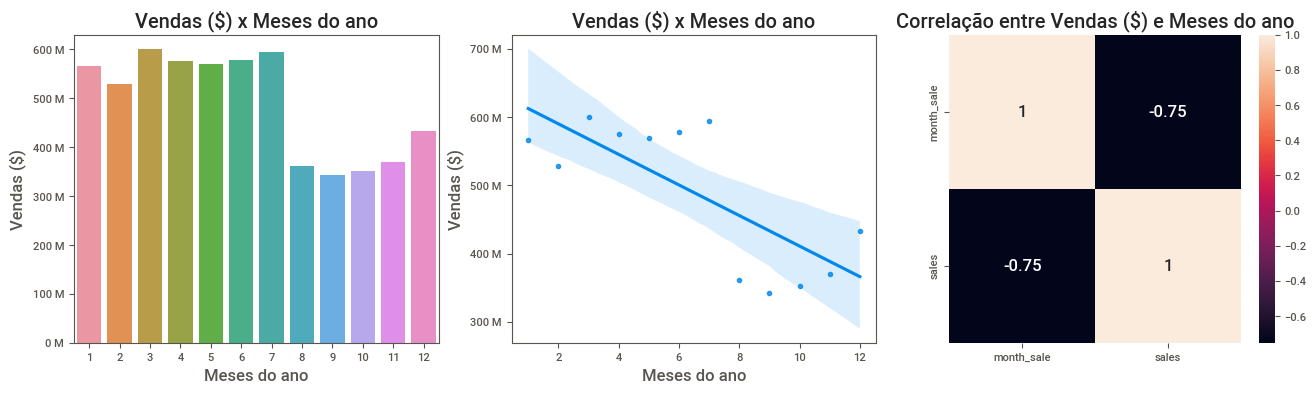

In [24]:
aux_h9 = df_eda[['month_sale','sales']].groupby('month_sale').sum().reset_index()

plt.rcParams["figure.figsize"] = (16, 4)
#linha, coluna, posição
plt.subplot(1, 3, 1)
h9_bar = sns.barplot (x='month_sale', y='sales', data=aux_h9);
h9_bar.ticklabel_format(style='plain', axis='y') #remover scientific notation
h9_bar.set_title('Vendas ($) x Meses do ano');
h9_bar.set_ylabel('Vendas ($)');
h9_bar.set_xlabel('Meses do ano');
ax = plt.gca() #configurar grandeza numérica no eixo
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + ' M'))

plt.subplot(1, 3, 2)
h9_reg = sns.regplot (x='month_sale', y='sales', data=aux_h9);
h9_reg.ticklabel_format(style='plain', axis='y') #remover scientific notation
h9_reg.set_title('Vendas ($) x Meses do ano');
h9_reg.set_ylabel('Vendas ($)');
h9_reg.set_xlabel('Meses do ano');
ax = plt.gca() #configurar grandeza numérica no eixo
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + ' M'))

plt.subplot(1, 3, 3)
h9_heat = sns.heatmap (aux_h9.corr(method='pearson'), annot=True );
h9_heat.set_title('Correlação entre Vendas ($) e Meses do ano');

- Analisando os gráficos superiores, percebemos que as lojas Rossmann venderem muito mais no primeiro semestre do que no segundo.
- A correlação negativa alta de -0,75, entre meses e vendas, refoça isto.
- Logo, a hipótese é **FALSA**: Lojas VENDEM MENOS no SEGUNDO SEMESTRE DO ANO.

### (H12 - sazo) Lojas deveriam vender menos durante os feriados escolares.

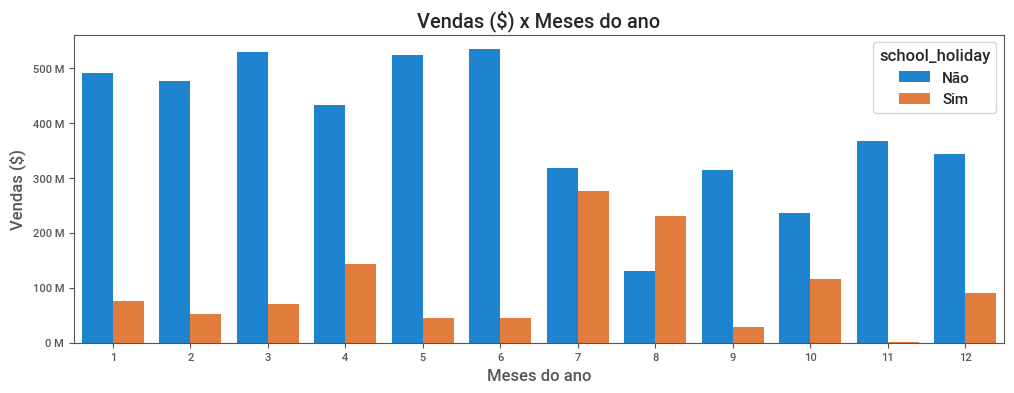

In [27]:
#Plotar Vendas ($) x Meses do ano abertos:
plt.rcParams["figure.figsize"] = (12, 4)
aux_h12 = df_eda[['month_sale', 'school_holiday','sales']].groupby( ['month_sale','school_holiday'] ).sum().reset_index()
aux_h12['school_holiday'] = aux_h12['school_holiday'].apply( lambda x: 'Sim' if x == 1 else 'Não' ) #ajustar legendas de school_holiday
h12_bar = sns.barplot (x='month_sale', y='sales', data=aux_h12, hue='school_holiday');
h12_bar.ticklabel_format(style='plain', axis='y') #remover scientific notation
h12_bar.set_title('Vendas ($) x Meses do ano');
h12_bar.set_ylabel('Vendas ($)');
h12_bar.set_xlabel('Meses do ano');
ax = plt.gca() #configurar grandeza numérica no eixo
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + ' M'))

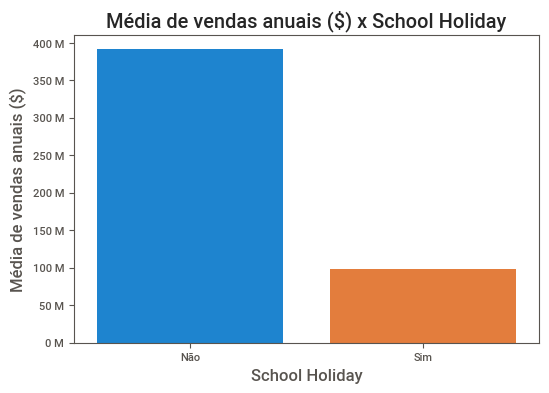

In [28]:
#Qual é a média de vendas anual por school_holiday?
plt.rcParams["figure.figsize"] = (6, 4)
aux_12_mean = aux_h12[['sales','school_holiday']].groupby('school_holiday').mean().reset_index()
h12_bar = sns.barplot (x='school_holiday', y='sales', data=aux_12_mean);
h12_bar.ticklabel_format(style='plain', axis='y') #remover scientific notation
h12_bar.set_title('Média de vendas anuais ($) x School Holiday');
h12_bar.set_ylabel('Média de vendas anuais ($)');
h12_bar.set_xlabel('School Holiday');
ax = plt.gca() #configurar grandeza numérica no eixo
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + ' M'))

- Alisando o gráfico anterior, percebemos que com exceção do mês de agosto, as vendas são consideravelmente maiores fora dos feriados escolares.
- Considerando a média de vendas anual nos feriados escolares e fora deles (gráfico acima), é visível que vende-se muito mais fora dos feriados.
- Logo, a hipótese é **VERDADEIRA**: Lojas VENDEM MENOS durante os FERIADOS ESCOLARES.

### Resumo das Hipóteses

In [29]:
tab = [['Hipoteses', 'Conclusão', 'Relevância Estimada'],
       ['H4', 'Falsa', 'Baixa'],
       ['H9', 'Falsa', 'Média'],
       ['H12', 'Verdadeira', 'Média']
      ]
print(tabulate(tab, headers='firstrow', stralign='center'))
#tablefmt='pipe', tablefmt='grid'

 Hipoteses    Conclusão    Relevância Estimada
-----------  -----------  ---------------------
    H4          Falsa             Baixa
    H9          Falsa             Média
    H12      Verdadeira           Média


## Análise Multivariada

- Responde: Como as variáveis impactam nas outras, e como elas juntas impactam na variável resposta.
- Vide Sweetviz.

In [30]:
df_eda.sample(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,month_sale
3498,160,2,2015-07-28,5984,regular_day,1,d,extended,17110,11,2005,1,0,31,2015,0,2015-07-27,0,7
383935,169,2,2014-05-13,6391,regular_day,0,d,basic,980,7,2014,0,1,18,2014,1,2014-04-28,2,5
583234,394,3,2013-10-09,7878,regular_day,0,d,basic,10850,10,2013,1,0,41,2013,0,2013-10-07,0,10


In [31]:
#Save CSV:
df_eda.to_csv('../data/5_eda_done.csv', index=False)

# Passo 5 - Data Preparation

In [14]:
df_pre = pd.read_csv('../data/5_eda_done.csv', low_memory=False, parse_dates=['date', 'promo_ext_init'])

In [15]:
df_pre.sample(3)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,month_sale
399381,1014,6,2014-04-26,5336,regular_day,0,a,extended,210,4,2014,0,1,31,2013,1,2013-07-29,38,4
130649,205,3,2015-03-11,4751,regular_day,0,a,basic,110,12,2007,0,0,11,2015,0,2015-03-09,0,3
397262,41,1,2014-04-28,6862,regular_day,0,d,extended,1180,4,2014,1,1,31,2013,1,2013-07-29,39,4


In [22]:
#obter colunas
df_pre.columns

Index(['store', 'day_of_week', 'date', 'sales', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'compet_distance',
       'compet_init_month', 'compet_init_year', 'promo_today', 'promo_ext',
       'promo_ext_init_week', 'promo_ext_init_year', 'promo_ext_today',
       'promo_ext_init', 'promo_ext_active_weeks', 'month_sale'],
      dtype='object')

Separação das features para preparação:
- De natureza cíclica (se repetem ao longo do tempo): day_of_week, compet_init_month, promo_ext_init_week, month_sale
- Categóricas, tratadas com transformações: state_holiday, store_type, assortment.
 - Categóricas, já em estado numérico (dipensam tratativa): school_holiday, promo_today, promo_ext, promo_ext_today 
- Variável resposta, onde vamos aplicar uma transoformação logaritmica: sales
- Numéricas, tratadas com scaling: store, compet_distance, compet_init_year, promo_ext_init_year, promo_ext_active_weeks
- Datas, que seguirão como estão: date, month_sale
- Granulariade: store 

In [ ]:
DUVIDAS:
- Porque store, que foi usada nos modelos, não foi reescalada no DS_PROD? 
    - Porque é a granularidade..?


## Scaling

1 - Feature Scaling: Trazer todas variáveis p/ mesmo range (escala), p/ não enviesar o modelo. 
- 1.1 **Standardization** se distribuição Normal:
 - Sem outliers: usa standard scaler
 - Com outliers: usa robust scaler

- 1.2 **Normalization** se não normal:
 - Com ou sem outliers: Usa min-max-scaler

- Avaliando as distribuições das features pelo SweetViz, não há nenhuma com distribuição normal, logo, vamos reescalar com min-max-scaler.
- Min-Max Scaler: Rescala para o intervalo entre 0 e 1. Dados caem no mesmo range.

In [25]:
#Numéricas, tratadas com scaling: compet_distance, compet_init_year, promo_ext_init_year, promo_ext_active_weeks

#Min Max Scaller:
mms = MinMaxScaler()
df_pre['compet_distance'] = mms.fit_transform(df_pre[['compet_distance']].values )
df_pre['compet_init_year'] = mms.fit_transform(df_pre[['compet_init_year']].values ) 
df_pre['promo_ext_init_year'] = mms.fit_transform(df_pre[['promo_ext_init_year']].values ) 
df_pre['promo_ext_active_weeks'] = mms.fit_transform(df_pre[['promo_ext_active_weeks']].values ) 

In [29]:
#ok
df_pre[['compet_distance','compet_init_year','promo_ext_init_year','promo_ext_active_weeks']].sample(3)

,compet_distance,compet_init_year,promo_ext_init_year,promo_ext_active_weeks
362721,0.033303,0.982609,0.833333,0.000000
25946,0.000850,1.000000,0.000000,0.942492
572465,0.072907,1.000000,0.666667,0.000000


## Transfotions

2 - Transformação: 
- 2.1 - Converter variáveis categóricas em numéricas (Encoding).
- 2.2 - Converter a variável resposta em distribuição normal.(Response Variable Transf.)
- 2.3 - Converter variáveis de natureza cíclica. (Nature Transformation)

### Encoding

2.1 - Encodings
- É a Conversão de Features Categóricas para Numéricas, mantendo o conteúdo. 
- Existem mais de 10 tipos de encoding.

In [ ]:
#- Categóricas, tratadas com transformações: state_holiday, store_type, assortment.
# - Categóricas, já em estado numérico (dipensam tratativa): school_holiday, promo_today, promo_ext, promo_ext_today 

In [56]:
df_pre.sample(2)

,store,day_of_week,date,sales,state_holiday,school_holiday,store_type,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,month_sale
479742,925,4,2014-01-30,5123,regular_day,0,c,basic,0.002250,3,0.930435,0,1,1,0.500000,1,2011-12-26,0.348243,1
431733,883,5,2014-03-21,5174,regular_day,0,a,basic,0.015902,6,0.913043,1,0,12,0.833333,0,2014-03-17,0.000000,3


In [57]:
#state_holiday: é um estado, estou num estado de natal, depois vou pra estado de dias normais. Vou usar one hot encoding aqui:
df_pre = pd.get_dummies( df_pre, prefix=['state_holiday'], columns=['state_holiday'] )

#store_type: 4 tipos de lojas, vamos aplicar one hot encoding também:
df_pre = pd.get_dummies( df_pre, prefix=['store_type'], columns=['store_type'] )

#assortment: representa uma ordem, sendo: basic, extra, e extended, então vamos manter esta ordem com Ordinal Encoding:
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df_pre['assortment'] = df_pre['assortment'].map( assortment_dict )

In [66]:
#verificar as alterações no dataset:
df_pre.tail(5)

,store,day_of_week,date,sales,school_holiday,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,month_sale,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d
844333,682,2,2013-01-01,3375,1,1,0.000650,9,0.921739,0,0,1,0.666667,0,2012-12-31,0.000000,1,0,0,1,0,0,1,0,0
844334,733,2,2013-01-01,10765,1,2,0.004200,10,0.860870,0,0,1,0.666667,0,2012-12-31,0.000000,1,0,0,1,0,0,1,0,0
844335,769,2,2013-01-01,5035,1,2,0.004100,1,0.982609,0,1,48,0.500000,1,2012-11-19,0.019169,1,0,0,1,0,0,1,0,0
844336,948,2,2013-01-01,4491,1,2,0.007051,1,0.982609,0,0,1,0.666667,0,2012-12-31,0.000000,1,0,0,1,0,0,1,0,0
844337,1097,2,2013-01-01,5961,1,2,0.003500,3,0.886957,0,0,1,0.666667,0,2012-12-31,0.000000,1,0,0,1,0,0,1,0,0


### Response Variable Transformation

2.2 - Aplica um log na variável resposta, transformando ela em algo próximo a uma distribuição normal. (Response Variable Transf.)

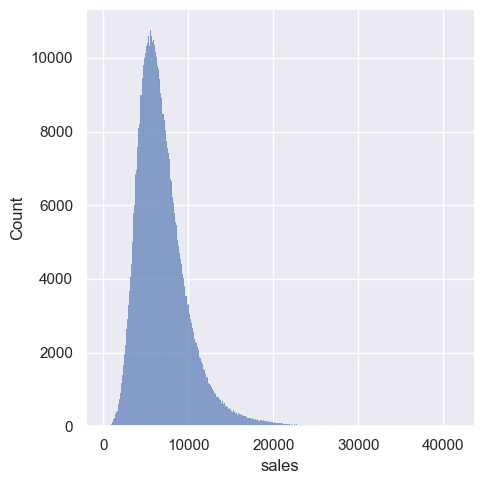

In [69]:
#Notamos que sales atualmente tem uma skew positiva leve:
sns.displot( df_pre['sales'] );

In [70]:
#vamos normalizar com Transformação Logarítmica:
df_pre['sales'] = np.log1p (df_pre['sales'] )

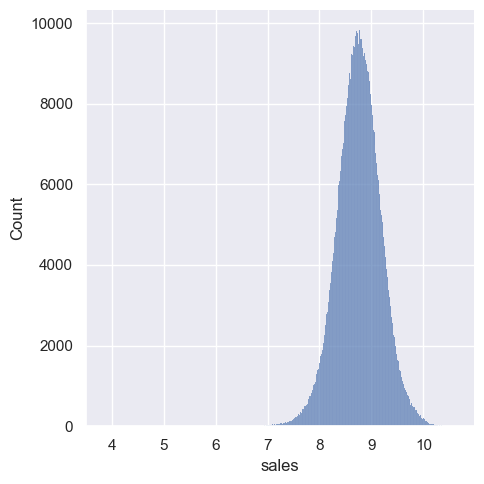

In [72]:
#distribuição normalizada:
sns.displot( df_pre['sales'] );

### Nature Transformation

2.3 - Converter variáveis de natureza cíclica. (se repetem ao longo do tempo)
Utiliza círculo trigonométrico. Vai converter por exemplo a variável mês em duas colunas: Seno e Cosseno. Combinadas, vão representar a natureza cíclica. Assim, a distância entre dez e jan é a mesma de jan e fev.

In [ ]:
# De natureza cíclica: day_of_week, compet_init_month, promo_ext_init_week, month_sale

In [87]:
df_pre[::10000].head()

,store,day_of_week,date,sales,school_holiday,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,month_sale,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d
0,1,5,2015-07-31,8.568646,1,1,0.006251,9,0.939130,1,0,31,1.000000,0,2015-07-27,0.000000,7,0,0,0,1,0,0,1,0
10000,1067,3,2015-07-22,8.523772,0,3,0.060006,7,0.947826,0,0,30,1.000000,0,2015-07-20,0.000000,7,0,0,0,1,0,0,0,1
20000,988,6,2015-07-11,8.449128,0,1,0.000050,11,0.973913,0,0,28,1.000000,0,2015-07-06,0.000000,7,0,0,0,1,1,0,0,0
30000,928,3,2015-07-01,9.102310,1,3,0.005351,7,1.000000,1,1,31,0.666667,0,2013-07-29,0.319489,7,0,0,0,1,0,0,0,1
40000,834,6,2015-06-20,7.943783,0,1,0.017252,3,0.973913,0,0,25,1.000000,0,2015-06-15,0.000000,6,0,0,0,1,1,0,0,0


In [94]:
#day_of_week
df_pre['day_of_week_sin'] = df_pre['day_of_week'].apply (lambda x: np.sin(x * ( 2. * np.pi/7 ) ) )
df_pre['day_of_week_cos'] = df_pre['day_of_week'].apply (lambda x: np.cos(x * ( 2. * np.pi/7 ) ) )

#compet_init_month
df_pre['compet_init_month_sin'] = df_pre['compet_init_month'].apply (lambda x: np.sin(x * ( 2. * np.pi/12 ) ) )
df_pre['compet_init_month_cos'] = df_pre['compet_init_month'].apply (lambda x: np.cos(x * ( 2. * np.pi/12 ) ) )

#promo_ext_init_week
df_pre['promo_ext_init_week_sin'] = df_pre['promo_ext_init_week'].apply (lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
df_pre['promo_ext_init_week_cos'] = df_pre['promo_ext_init_week'].apply (lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )

#month_sale
df_pre['month_sale_sin'] = df_pre['month_sale'].apply (lambda x: np.sin(x * ( 2. * np.pi/12 ) ) )
df_pre['month_sale_cos'] = df_pre['month_sale'].apply (lambda x: np.cos(x * ( 2. * np.pi/12 ) ) )

In [96]:
#ok!
df_pre[::10000].head()

,store,day_of_week,date,sales,school_holiday,assortment,compet_distance,compet_init_month,compet_init_year,promo_today,promo_ext,promo_ext_init_week,promo_ext_init_year,promo_ext_today,promo_ext_init,...,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_sin,month_sale_cos
0,1,5,2015-07-31,8.568646,1,1,0.006251,9,0.939130,1,0,31,1.000000,0,2015-07-27,...,0,0,1,0,0,1,0,-0.974928,-0.222521,-1.0,-1.836970e-16,-0.568065,-0.822984,-5.000000e-01,-0.866025
10000,1067,3,2015-07-22,8.523772,0,3,0.060006,7,0.947826,0,0,30,1.000000,0,2015-07-20,...,0,0,1,0,0,0,1,0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-5.000000e-01,-0.866025
20000,988,6,2015-07-11,8.449128,0,1,0.000050,11,0.973913,0,0,28,1.000000,0,2015-07-06,...,0,0,1,1,0,0,0,-0.781831,0.623490,-0.5,8.660254e-01,-0.239316,-0.970942,-5.000000e-01,-0.866025
30000,928,3,2015-07-01,9.102310,1,3,0.005351,7,1.000000,1,1,31,0.666667,0,2013-07-29,...,0,0,1,0,0,0,1,0.433884,-0.900969,-0.5,-8.660254e-01,-0.568065,-0.822984,-5.000000e-01,-0.866025
40000,834,6,2015-06-20,7.943783,0,1,0.017252,3,0.973913,0,0,25,1.000000,0,2015-06-15,...,0,0,1,1,0,0,0,-0.781831,0.623490,1.0,6.123234e-17,0.120537,-0.992709,1.224647e-16,-1.000000


In [109]:
#remover agora as features originais, que originaram as novas de natureza transformada, e não são mais necessárias:
cols_drop = ['day_of_week','compet_init_month','promo_ext_init_week','month_sale']
df_pre = df_pre.drop( cols_drop, axis=1) 

In [110]:
#Save CSV:
df_pre.to_csv('../data/6_data_preparation_done.csv', index=False)

# Passo 6 - Feature Selection

In [7]:
df_fea = pd.read_csv('../data/6_data_preparation_done.csv', low_memory=False, parse_dates=['date', 'promo_ext_init'])

In [8]:
df_fea.head(3)

,store,date,sales,school_holiday,assortment,compet_distance,compet_init_year,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_sin,month_sale_cos
0,1,2015-07-31,8.568646,1,1,0.006251,0.939130,1,0,1.000000,0,2015-07-27,0.000000,0,0,0,1,0,0,1,0,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,-0.568065,-8.229839e-01,-0.5,-0.866025
1,2,2015-07-31,8.710290,1,1,0.002750,0.930435,1,1,0.166667,1,2010-03-22,0.891374,0,0,0,1,1,0,0,0,-0.974928,-0.222521,-5.000000e-01,8.660254e-01,1.000000,6.123234e-17,-0.5,-0.866025
2,3,2015-07-31,9.025816,1,1,0.070557,0.921739,1,1,0.333333,1,2011-03-28,0.722045,0,0,0,1,1,0,0,0,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,0.992709,-1.205367e-01,-0.5,-0.866025


## Split dataframe into training and test dataset

- Dados de treino: parte do dataset usada pra trainar o modelo.
- Dados de teste: parte do dataset usado pra medir a acurácia.
    Dado de teste é para simular dado de produção, e não temos a variável resposta nele.

Sendo um problema de time series, vou pegar as últimas 6 semanas de venda (as mais importantes, pois são mais próximas da data atual e devem refletir a realidade ao máximo), e separar isto para teste.

Todas as vendas antes disso, serão treino.

In [9]:
#pegar data mínima (inicial) de venda de cada loja:
df_fea[['store', 'date']].groupby( 'store' ).min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [10]:
#pegar data máxima (final) de venda de cada loja:
df_fea[['store', 'date']].groupby( 'store' ).max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [11]:
#pegar 60 dias antes da última data
df_fea[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - dt.timedelta( days=6*7 ) 

Timestamp('2015-06-19 00:00:00')

In [12]:
#Dinâmica:
# X = dataset todo
# Y = var resposta

#training dataset:
X_train = df_fea[df_fea['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset:
X_test = df_fea[df_fea['date'] >= '2015-06-19']
y_test = X_test['sales']

#Conferência das data (ok)
print ('Traning Min Date: ',X_train['date'].min() )
print ('Traning Max Date: ', X_train['date'].max() )

print ('\nTest Min Date: ', X_test['date'].min() )
print ('Test Max Date: ', X_test['date'].max() )

Traning Min Date:  2013-01-01 00:00:00
Traning Max Date:  2015-06-18 00:00:00

Test Min Date:  2015-06-19 00:00:00
Test Max Date:  2015-07-31 00:00:00


In [18]:
#falta remover sales pra ser X
X_train.head(1)

,store,date,sales,school_holiday,assortment,compet_distance,compet_init_year,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_sin,month_sale_cos
41396,1,2015-06-18,8.443762,0,1,0.006251,0.93913,1,0,1.0,0,2015-06-15,0.0,0,0,0,1,0,0,1,0,-0.433884,-0.900969,-1.0,-1.836970e-16,0.120537,-0.992709,1.224647e-16,-1.0


In [19]:
#falta remover sales pra ser X
X_test.head(1)

,store,date,sales,school_holiday,assortment,compet_distance,compet_init_year,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_init,promo_ext_active_weeks,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_sin,month_sale_cos
0,1,2015-07-31,8.568646,1,1,0.006251,0.93913,1,0,1.0,0,2015-07-27,0.0,0,0,0,1,0,0,1,0,-0.974928,-0.222521,-1.0,-1.836970e-16,-0.568065,-0.822984,-0.5,-0.866025


In [20]:
#criando datasets full, que vão manter 'date' e 'sales', que serão necessários adiante
df_train_full = X_train.copy()
df_test_full = X_test.copy()

In [22]:
#para X_train e X_test, remover 'promo_ext_init', utilizada apenas na EDA, 'date', usado para controle dos splits, e sales, sendo a var resposta, logo não deve estar em X
X_train = X_train.drop( ['date', 'sales', 'promo_ext_init'],axis=1 )
X_test = X_test.drop( ['date', 'sales', 'promo_ext_init'],axis=1 )
#-> removi, pois senão o feature selectin complica com as datas feature selection vai naturalmente fazer isso em breve

In [36]:
X_train.head(3)

,store,school_holiday,assortment,compet_distance,compet_init_year,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_sin,month_sale_cos
41396,1,0,1,0.006251,0.939130,1,0,1.000000,0,0.000000,0,0,0,1,0,0,1,0,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,0.120537,-9.927089e-01,1.224647e-16,-1.0
41397,2,0,1,0.002750,0.930435,1,1,0.166667,0,0.872204,0,0,0,1,1,0,0,0,-0.433884,-0.900969,-5.000000e-01,8.660254e-01,1.000000,6.123234e-17,1.224647e-16,-1.0
41398,3,0,1,0.070557,0.921739,1,1,0.333333,0,0.702875,0,0,0,1,1,0,0,0,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,0.992709,-1.205367e-01,1.224647e-16,-1.0


In [73]:
X_train.shape

(802942, 26)

In [38]:
#whole dataset - test
X_test.head(3)

,store,school_holiday,assortment,compet_distance,compet_init_year,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,store_type_a,store_type_b,store_type_c,store_type_d,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_sin,month_sale_cos
0,1,1,1,0.006251,0.939130,1,0,1.000000,0,0.000000,0,0,0,1,0,0,1,0,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,-0.568065,-8.229839e-01,-0.5,-0.866025
1,2,1,1,0.002750,0.930435,1,1,0.166667,1,0.891374,0,0,0,1,1,0,0,0,-0.974928,-0.222521,-5.000000e-01,8.660254e-01,1.000000,6.123234e-17,-0.5,-0.866025
2,3,1,1,0.070557,0.921739,1,1,0.333333,1,0.722045,0,0,0,1,1,0,0,0,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,0.992709,-1.205367e-01,-0.5,-0.866025


In [75]:
X_test.shape

(41396, 26)

In [76]:
#response var (já normalizada) - training
y_train.head(3)

41396    8.443762
41397    8.547722
41398    8.927712
Name: sales, dtype: float64

In [77]:
y_train.shape

(802942,)

In [78]:
#response var (já normalizada) - test 
y_test.head(3)

0    8.568646
1    8.710290
2    9.025816
Name: sales, dtype: float64

In [79]:
y_test.shape

(41396,)

## Univariate Statistics

- Na estatística univariada, calculamos se existe uma relação estatisticamente significativa entre cada feature e a var alvo. 
- As features que são relacionadas com o maior grau de confiança, são selecionadas.
- Considera apenas cada feature individualmente x alvo, logo se duas combinadas se tornassem informativas, perderia elas, caso sozinhas não fossem.
- Irá manter a porcentagem (a definir abaixo) de features com menor P Valor, que significa que elas provavelmente estão mais relacionadas com o alvo.

In [44]:
select = SelectPercentile(score_func=f_regression, percentile=50) #score_func=f_regression para regressão
select.fit(X_train, y_train)
X_train_sel_sta = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_sel_sta.shape: {}".format(X_train_sel_sta.shape))

X_train.shape: (802942, 26)
X_train_sel_sta.shape: (802942, 13)


[False  True  True  True False  True  True  True  True  True False False
 False False  True  True False False  True False False  True  True False
 False False]


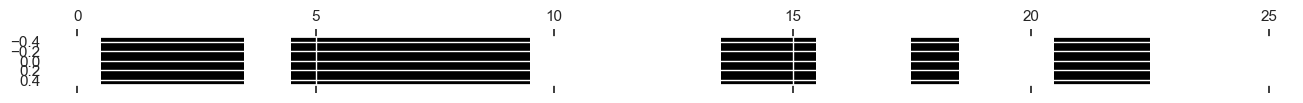

In [45]:
#método para identificar as features selecionadas
mask_sel_sta = select.get_support()
print(mask_sel_sta)
# visualize the mask -- black is True, white is False
plt.matshow(mask_sel_sta.reshape(1, -1), cmap='gray_r');

In [47]:
# Verificar quais são as x % features selecionadas:
X_train.loc[:, [False, True, True, True, False, True , True, True, True, True, False, False,
 False, False, True, True, False, False, True, False, False, True, True, False, False, False]].head(3)
# as features mais informativas por ordem são: promo_today, day_of_week_sin, assortment, promo_ext, day_of_week_sin

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin
41396,0,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537
41397,0,1,0.002750,1,1,0.166667,0,0.872204,1,0,-0.433884,8.660254e-01,1.000000
41398,0,1,0.070557,1,1,0.333333,0,0.702875,1,0,-0.433884,1.000000e+00,0.992709


In [49]:
features_selected_sta = X_train.loc[:, 
                [False, True, True, True, False, True , True, True, True, True, False, False,
 False, False, True, True, False, False, True, False, False, True, True, False, False, False]].columns
features_selected_sta

Index(['school_holiday', 'assortment', 'compet_distance', 'promo_today',
       'promo_ext', 'promo_ext_init_year', 'promo_ext_today',
       'promo_ext_active_weeks', 'store_type_a', 'store_type_b',
       'day_of_week_sin', 'compet_init_month_cos', 'promo_ext_init_week_sin'],
      dtype='object')

## Model-Based Feature Selection

- Usa ML para julgar a importância das features, e manter as mais importantes. Bem mais poderoso que o anterior.
- O modelo precisa prover alguma medida de importância, para que as features sejam ranqueadas por esta medida.
 - Modelos baseados em árvore provêem o atributo faeture_importances_, que encoda a importância de cada feature.
 - Modelos lineares tem coefficients, que também podem ser usados para isto.
- Uso a partir do sklearn: SelectFromModel. Usaremos uma RandomForest com 100 árvores, e threshhold = mediana.
- Diferente da Univariate Statistics, seleciona todas as features de uma vez, então consegue capturar interactions (se o modelo puder capturá-las).

In [53]:
#criar modelo de árvore de features selection que com base na mediana, pega as (50%) features com mais importância:
select = SelectFromModel( RandomForestRegressor(n_estimators=30, random_state=42), threshold="median") #3 n_estimators: 17 seg, 10 árvores=1min, 20 árvores=2min, 30 árvores=2min56seg
                                                                                                        #não houve alteração nas 50% melhores features escolhidas com 3 ou com 30 n_estimators.
#treina e utiliza o modeo
select.fit(X_train, y_train)
X_train_sel_mbf = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_sel_mbf.shape: {}".format(X_train_sel_mbf.shape))

X_train.shape: (802942, 26)
X_train_sel_mbf.shape: (802942, 13)


[ True False False  True  True  True False  True False  True False False
 False False False False False False  True  True  True  True  True  True
 False  True]


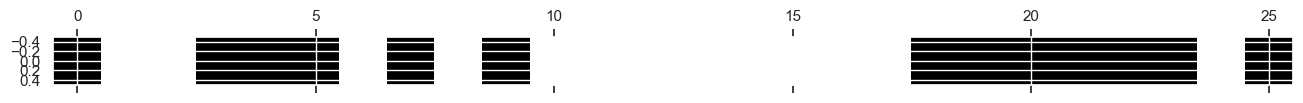

In [54]:
#método para identificar as features selecionadas
mask_sel_mbf = select.get_support()
print(mask_sel_mbf)
# visualize the mask -- black is True, white is False
plt.matshow(mask_sel_mbf.reshape(1, -1), cmap='gray_r');

In [56]:
# Verificar quais são as 50% melhores features selecionadas:
X_train.loc[:, [True, False, False, True, True, True , False, True, False, True, False, False,
 False, False, False, False, False, False, True, True, True, True, True, True, False, True]].head(3)

,store,compet_distance,compet_init_year,promo_today,promo_ext_init_year,promo_ext_active_weeks,day_of_week_sin,day_of_week_cos,compet_init_month_sin,compet_init_month_cos,promo_ext_init_week_sin,promo_ext_init_week_cos,month_sale_cos
41396,1,0.006251,0.939130,1,1.000000,0.000000,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,0.120537,-9.927089e-01,-1.0
41397,2,0.002750,0.930435,1,0.166667,0.872204,-0.433884,-0.900969,-5.000000e-01,8.660254e-01,1.000000,6.123234e-17,-1.0
41398,3,0.070557,0.921739,1,0.333333,0.702875,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,0.992709,-1.205367e-01,-1.0


In [57]:
features_selected_mbf = X_train.loc[:, [True, False, False, True, True, True , False, True, False, True, False, False,
 False, False, False, False, False, False, True, True, True, True, True, True, False, True]].columns
features_selected_mbf

Index(['store', 'compet_distance', 'compet_init_year', 'promo_today',
       'promo_ext_init_year', 'promo_ext_active_weeks', 'day_of_week_sin',
       'day_of_week_cos', 'compet_init_month_sin', 'compet_init_month_cos',
       'promo_ext_init_week_sin', 'promo_ext_init_week_cos', 'month_sale_cos'],
      dtype='object')

## Custom Feature Selection

In [ ]:
#features_selected_sta com 13 features:
# Index(['school_holiday', 'assortment', 'compet_distance', 'promo_today',
#        'promo_ext', 'promo_ext_init_year', 'promo_ext_today',
#        'promo_ext_active_weeks', 'store_type_a', 'store_type_b',
#        'day_of_week_sin', 'compet_init_month_cos', 'promo_ext_init_week_sin'],
#       dtype='object')

In [ ]:
#features_selected_mbf com 13 features:
# Index(['store', 'compet_distance', 'compet_init_year', 'promo_today',
#        'promo_ext_init_year', 'promo_ext_active_weeks', 'day_of_week_sin',
#        'day_of_week_cos', 'compet_init_month_sin', 'compet_init_month_cos',
#        'promo_ext_init_week_sin', 'promo_ext_init_week_cos', 'month_sale_cos'],
#       dtype='object')

In [26]:
#combinação de features dos dois modelos, totalizando 19 features:
features_selected_final= ['school_holiday', 'assortment', 'compet_distance', 'promo_today', 'promo_ext', 'promo_ext_init_year', 'promo_ext_today',
                           'promo_ext_active_weeks', 'store_type_a', 'store_type_b', 'day_of_week_sin', 'compet_init_month_cos', 'promo_ext_init_week_sin',
                            'store',  'compet_init_year', 'day_of_week_cos', 'compet_init_month_sin', 'promo_ext_init_week_cos', 'month_sale_cos' ]

Manter apenas as features selecionadas no X_train, X_test, df_train_full e df_test_full:

In [128]:
X_train = X_train[features_selected_final] #ok
X_test = X_test[features_selected_final] #ok

In [141]:
X_train

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos
41396,0,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,1,0.939130,-0.900969,-1.000000e+00,-9.927089e-01,-1.000000
41397,0,1,0.002750,1,1,0.166667,0,0.872204,1,0,-0.433884,8.660254e-01,1.000000,2,0.930435,-0.900969,-5.000000e-01,6.123234e-17,-1.000000
41398,0,1,0.070557,1,1,0.333333,0,0.702875,1,0,-0.433884,1.000000e+00,0.992709,3,0.921739,-0.900969,-2.449294e-16,-1.205367e-01,-1.000000
41399,0,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,4,0.947826,-0.900969,-1.000000e+00,-9.927089e-01,-1.000000
41400,0,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.433884,-5.000000e-01,0.120537,5,1.000000,-0.900969,8.660254e-01,-9.927089e-01,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1,1,0.000650,0,0,0.666667,0,0.000000,0,1,0.974928,-1.836970e-16,0.120537,682,0.921739,-0.222521,-1.000000e+00,9.927089e-01,0.866025
844334,1,2,0.004200,0,0,0.666667,0,0.000000,0,1,0.974928,5.000000e-01,0.120537,733,0.860870,-0.222521,-8.660254e-01,9.927089e-01,0.866025
844335,1,2,0.004100,0,1,0.500000,1,0.019169,0,1,0.974928,8.660254e-01,-0.464723,769,0.982609,-0.222521,5.000000e-01,8.854560e-01,0.866025
844336,1,2,0.007051,0,0,0.666667,0,0.000000,0,1,0.974928,8.660254e-01,0.120537,948,0.982609,-0.222521,5.000000e-01,9.927089e-01,0.866025


In [142]:
X_test

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos
0,1,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.939130,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025
1,1,1,0.002750,1,1,0.166667,1,0.891374,1,0,-0.974928,8.660254e-01,1.000000,2,0.930435,-0.222521,-5.000000e-01,6.123234e-17,-0.866025
2,1,1,0.070557,1,1,0.333333,1,0.722045,1,0,-0.974928,1.000000e+00,0.992709,3,0.921739,-0.222521,-2.449294e-16,-1.205367e-01,-0.866025
3,1,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,4,0.947826,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025
4,1,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.974928,-5.000000e-01,-0.568065,5,1.000000,-0.222521,8.660254e-01,-8.229839e-01,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41391,0,1,0.009401,1,1,0.666667,0,0.313099,1,0,-0.974928,-1.000000e+00,-0.568065,1111,0.991304,-0.222521,1.224647e-16,-8.229839e-01,-1.000000
41392,0,3,0.009301,1,0,1.000000,0,0.000000,0,0,-0.974928,-5.000000e-01,0.120537,1112,0.921739,-0.222521,8.660254e-01,-9.927089e-01,-1.000000
41393,0,3,0.046205,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1113,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000
41394,0,3,0.004250,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1114,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000


In [29]:
#df_train_full e df_test_full tem date e sales, mas em função das seleção final de features, não vai aparece:
df_train_full[features_selected_final]

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos
41396,0,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,1,0.939130,-0.900969,-1.000000e+00,-9.927089e-01,-1.000000
41397,0,1,0.002750,1,1,0.166667,0,0.872204,1,0,-0.433884,8.660254e-01,1.000000,2,0.930435,-0.900969,-5.000000e-01,6.123234e-17,-1.000000
41398,0,1,0.070557,1,1,0.333333,0,0.702875,1,0,-0.433884,1.000000e+00,0.992709,3,0.921739,-0.900969,-2.449294e-16,-1.205367e-01,-1.000000
41399,0,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,4,0.947826,-0.900969,-1.000000e+00,-9.927089e-01,-1.000000
41400,0,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.433884,-5.000000e-01,0.120537,5,1.000000,-0.900969,8.660254e-01,-9.927089e-01,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1,1,0.000650,0,0,0.666667,0,0.000000,0,1,0.974928,-1.836970e-16,0.120537,682,0.921739,-0.222521,-1.000000e+00,9.927089e-01,0.866025
844334,1,2,0.004200,0,0,0.666667,0,0.000000,0,1,0.974928,5.000000e-01,0.120537,733,0.860870,-0.222521,-8.660254e-01,9.927089e-01,0.866025
844335,1,2,0.004100,0,1,0.500000,1,0.019169,0,1,0.974928,8.660254e-01,-0.464723,769,0.982609,-0.222521,5.000000e-01,8.854560e-01,0.866025
844336,1,2,0.007051,0,0,0.666667,0,0.000000,0,1,0.974928,8.660254e-01,0.120537,948,0.982609,-0.222521,5.000000e-01,9.927089e-01,0.866025


In [136]:
#Vamos acrescentar estas 2 nestes dois datasets, além as 19 features selecionadas:
#columns a adicionar
feat_to_add = ['date', 'sales']
#cria lista 'features_selected_final_full' com 'date' e 'sales', pra manter 'features_selected_final' (lista original) sem eles.
features_selected_final_full = features_selected_final.copy()
features_selected_final_full.extend (feat_to_add) #extend adiciona uma lista na outra

In [139]:
#continuando: 
df_train_full = df_train_full[features_selected_final_full] #ok
df_test_full = df_test_full[features_selected_final_full] #ok

In [143]:
df_train_full

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales
41396,0,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,1,0.939130,-0.900969,-1.000000e+00,-9.927089e-01,-1.000000,2015-06-18,8.443762
41397,0,1,0.002750,1,1,0.166667,0,0.872204,1,0,-0.433884,8.660254e-01,1.000000,2,0.930435,-0.900969,-5.000000e-01,6.123234e-17,-1.000000,2015-06-18,8.547722
41398,0,1,0.070557,1,1,0.333333,0,0.702875,1,0,-0.433884,1.000000e+00,0.992709,3,0.921739,-0.900969,-2.449294e-16,-1.205367e-01,-1.000000,2015-06-18,8.927712
41399,0,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,4,0.947826,-0.900969,-1.000000e+00,-9.927089e-01,-1.000000,2015-06-18,9.091669
41400,0,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.433884,-5.000000e-01,0.120537,5,1.000000,-0.900969,8.660254e-01,-9.927089e-01,-1.000000,2015-06-18,8.502080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1,1,0.000650,0,0,0.666667,0,0.000000,0,1,0.974928,-1.836970e-16,0.120537,682,0.921739,-0.222521,-1.000000e+00,9.927089e-01,0.866025,2013-01-01,8.124447
844334,1,2,0.004200,0,0,0.666667,0,0.000000,0,1,0.974928,5.000000e-01,0.120537,733,0.860870,-0.222521,-8.660254e-01,9.927089e-01,0.866025,2013-01-01,9.284148
844335,1,2,0.004100,0,1,0.500000,1,0.019169,0,1,0.974928,8.660254e-01,-0.464723,769,0.982609,-0.222521,5.000000e-01,8.854560e-01,0.866025,2013-01-01,8.524367
844336,1,2,0.007051,0,0,0.666667,0,0.000000,0,1,0.974928,8.660254e-01,0.120537,948,0.982609,-0.222521,5.000000e-01,9.927089e-01,0.866025,2013-01-01,8.410053


In [144]:
df_test_full

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales
0,1,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.939130,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,8.568646
1,1,1,0.002750,1,1,0.166667,1,0.891374,1,0,-0.974928,8.660254e-01,1.000000,2,0.930435,-0.222521,-5.000000e-01,6.123234e-17,-0.866025,2015-07-31,8.710290
2,1,1,0.070557,1,1,0.333333,1,0.722045,1,0,-0.974928,1.000000e+00,0.992709,3,0.921739,-0.222521,-2.449294e-16,-1.205367e-01,-0.866025,2015-07-31,9.025816
3,1,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,4,0.947826,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,9.546527
4,1,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.974928,-5.000000e-01,-0.568065,5,1.000000,-0.222521,8.660254e-01,-8.229839e-01,-0.866025,2015-07-31,8.481151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41391,0,1,0.009401,1,1,0.666667,0,0.313099,1,0,-0.974928,-1.000000e+00,-0.568065,1111,0.991304,-0.222521,1.224647e-16,-8.229839e-01,-1.000000,2015-06-19,8.633909
41392,0,3,0.009301,1,0,1.000000,0,0.000000,0,0,-0.974928,-5.000000e-01,0.120537,1112,0.921739,-0.222521,8.660254e-01,-9.927089e-01,-1.000000,2015-06-19,9.327323
41393,0,3,0.046205,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1113,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000,2015-06-19,8.869961
41394,0,3,0.004250,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1114,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000,2015-06-19,9.991269


In [32]:
#Save CSV:
df_fea.to_csv('../data/7_feature_selection.csv', index=False)

# Passo 7 - Machine Learning Modelling

In [145]:
#conferência de datas de x treino e x teste:
print ('Data inicial Treino: ', df_train_full[ features_selected_final_full ]['date'].min() )
print ('Data final Treino: ', df_train_full[ features_selected_final_full  ]['date'].max() )

print ('\nData inicial Teste: ', df_test_full[ features_selected_final_full  ]['date'].min() )
print ('Data final Teste: ', df_test_full[ features_selected_final_full  ]['date'].max() )

Data inicial Treino:  2013-01-01 00:00:00
Data final Treino:  2015-06-18 00:00:00

Data inicial Teste:  2015-06-19 00:00:00
Data final Teste:  2015-07-31 00:00:00


Agora, vamos testar alguns modelos:

## Average Model

É a média de vendas de cada uma das lojas.
Média é um modelo linear (para dados com comportamento mais simples)

In [ ]:
# Objetivo: obter as 3 métricas de erro do modelo de média (baseline),
# Para isto, precisamos passar para a função ml_error() o y_test, e yhat_baseline, sendo este a sendo a média de vendas da loja de cada registro em y_test.

#1 - Obter a média de vendas por loja de cada uma das 1114 lojas

In [146]:
# Usar 'df_test_full' por ele contém 'sales', necessário para a conta, mas cria novo 'df_ml_mean' para preservar o dataset anterior:
df_ml_mean = df_test_full.copy() #contem sales
df_ml_mean.head(1)

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales
0,1,1,0.006251,1,0,1.0,0,0.0,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.93913,-0.222521,-1.0,-0.822984,-0.866025,2015-07-31,8.568646


In [147]:
#2 - Obtém a média de vendas por loja, chamando de 'store_sales_mean'
df_ml_mean_aux = df_ml_mean[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'store_sales_mean'} )
#1114 registro de 'store' e 'store_sales_mean'
df_ml_mean_aux.tail(3)

,store,store_sales_mean
1112,1113,8.774888
1113,1114,10.023617
1114,1115,8.827777


In [148]:
#3 Atualiza 'df_ml_mean' com a feature 'store_sales_mean', para que cada registro de teste agora receba a média de vendas
df_ml_mean = pd.merge(df_ml_mean, df_ml_mean_aux, how='left', on='store')

In [149]:
#confere se todos os registros de teste tem 'store_sales_mean':
df_ml_mean

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales,store_sales_mean
0,1,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.939130,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,8.568646,8.373392
1,1,1,0.002750,1,1,0.166667,1,0.891374,1,0,-0.974928,8.660254e-01,1.000000,2,0.930435,-0.222521,-5.000000e-01,6.123234e-17,-0.866025,2015-07-31,8.710290,8.460676
2,1,1,0.070557,1,1,0.333333,1,0.722045,1,0,-0.974928,1.000000e+00,0.992709,3,0.921739,-0.222521,-2.449294e-16,-1.205367e-01,-0.866025,2015-07-31,9.025816,8.795885
3,1,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,4,0.947826,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,9.546527,9.194715
4,1,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.974928,-5.000000e-01,-0.568065,5,1.000000,-0.222521,8.660254e-01,-8.229839e-01,-0.866025,2015-07-31,8.481151,8.346624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41391,0,1,0.009401,1,1,0.666667,0,0.313099,1,0,-0.974928,-1.000000e+00,-0.568065,1111,0.991304,-0.222521,1.224647e-16,-8.229839e-01,-1.000000,2015-06-19,8.633909,8.392352
41392,0,3,0.009301,1,0,1.000000,0,0.000000,0,0,-0.974928,-5.000000e-01,0.120537,1112,0.921739,-0.222521,8.660254e-01,-9.927089e-01,-1.000000,2015-06-19,9.327323,9.030286
41393,0,3,0.046205,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1113,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000,2015-06-19,8.869961,8.774888
41394,0,3,0.004250,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1114,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000,2015-06-19,9.991269,10.023617


In [150]:
yhat_baseline = df_ml_mean['store_sales_mean']
#'yhat_baseline' agora contém todos os registros de teste, cada um contendo 'store_sales_mean', no mesmo formato de y_test. Podemos agora passar ele na função ml_error() 
yhat_baseline 

0         8.373392
1         8.460676
2         8.795885
3         9.194715
4         8.346624
           ...    
41391     8.392352
41392     9.030286
41393     8.774888
41394    10.023617
41395     8.827777
Name: store_sales_mean, Length: 41396, dtype: float64

In [151]:
#Calcula o erro do modelo com função: ml_error( model_name, y, yhat )
#Usar np.expm1 aplicando o exponenencial para y_test e yhat_baseline, pois na Transf da Var Resposta, fizemos o log de vendas, e o oposto do log é o exponencial
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline)  )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## Linear Regression Model

In [159]:
X_train.head(3)

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos
41396,0,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.433884,-1.836970e-16,0.120537,1,0.939130,-0.900969,-1.000000e+00,-9.927089e-01,-1.0
41397,0,1,0.002750,1,1,0.166667,0,0.872204,1,0,-0.433884,8.660254e-01,1.000000,2,0.930435,-0.900969,-5.000000e-01,6.123234e-17,-1.0
41398,0,1,0.070557,1,1,0.333333,0,0.702875,1,0,-0.433884,1.000000e+00,0.992709,3,0.921739,-0.900969,-2.449294e-16,-1.205367e-01,-1.0


In [160]:
y_train.head(3)

41396    8.443762
41397    8.547722
41398    8.927712
Name: sales, dtype: float64

In [161]:
X_test.head(3)

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos
0,1,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.939130,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025
1,1,1,0.002750,1,1,0.166667,1,0.891374,1,0,-0.974928,8.660254e-01,1.000000,2,0.930435,-0.222521,-5.000000e-01,6.123234e-17,-0.866025
2,1,1,0.070557,1,1,0.333333,1,0.722045,1,0,-0.974928,1.000000e+00,0.992709,3,0.921739,-0.222521,-2.449294e-16,-1.205367e-01,-0.866025


Sem cross validation:

In [162]:
#treina uma regressão linear
lr = LinearRegression().fit( X_train, y_train)

#extrai previsão do modelo
yhat_lr = lr.predict ( X_test )

#calcula performance
lr_result = ml_error ( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1860.931347,0.294979,2632.091202


O Erro RMSE do modelo de regressão linear é muito maior que o erro do modelo de média, portanto:
- 1 - o modelo de média é melhor que a regressão linear com os dados atuais
- 2 - isto nos diz que os dados tem comportamento complexo (não linear), e muito provavelmente modelos não lineares não vão conseguir aprender este comportamento.

Vamos agora avaliar as métricas de erro através do método cross validation, que será detalhado a seguir.  

Com cross validation:

In [175]:
# vamos passar df_train_full ao invés de x_train, porque a função cross_validation() precisa dos campos 'date' e 'sales':
df_train_full.head(1)

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales
41396,0,1,0.006251,1,0,1.0,0,0.0,0,0,-0.433884,-1.836970e-16,0.120537,1,0.93913,-0.900969,-1.0,-0.992709,-1.0,2015-06-18,8.443762


In [177]:
df_train_full.shape

(802942, 21)

In [168]:
lr_result_cv = cross_validation( df_train_full, 5 , "Linear Regression", lr, verbose=True )
lr_result_cv


KFold Number:  5
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-11-19 00:00:00
kFold validation start date:  2014-11-20 00:00:00
kFold validation end date:  2015-01-01 00:00:00

KFold Number:  4
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-12-31 00:00:00
kFold validation start date:  2015-01-01 00:00:00
kFold validation end date:  2015-02-12 00:00:00

KFold Number:  3
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-02-11 00:00:00
kFold validation start date:  2015-02-12 00:00:00
kFold validation end date:  2015-03-26 00:00:00

KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:0

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.97 ± 306.2,0.3 ± 0.02,2943.07 ± 488.55


- Sem cross validation, RMSE foi de 2632. Com cross_validation, o RMSE foi de 2943. 
- Haviamos pego então um pedaço "bom" pra fazer a predição, e o erro sem cross validation foi menor.


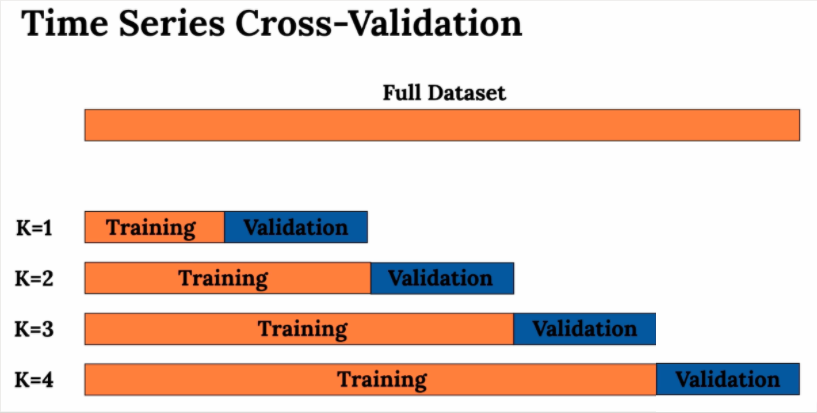

In [174]:
#Ilustração do Time Series Cross Validation
Image ('../img/time_series_cross_validation.png')

Cross Validation: método estatístico para avaliar a performance de generalização de modelos, avaliando as diferentes possíveis divisões do dataset.
- No exemplo acima, irá obter 4 resultados distintos das métricas de performance, e fazer uma média delas no final.
- Como resultado, temos métricas mais confiáveis do que a validação em cima de uma única porção do dataset de treino.

## Random Forest Regressor

Single perfomance

In [202]:
#fit
rf = RandomForestRegressor (n_estimators=100,
                            n_jobs=-1, #usar todas as threads
                            max_depth=6, #máxima profundidade da árvore
                            random_state=42 ).fit( X_train, y_train)

#predict
yhat_rf = rf.predict ( X_test )

#performance
rf_result = ml_error ( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1806.546406,0.272926,2580.307136


In [ ]:
# Cenário: max_depth=6, random_state=42, n_jobs=-1, variando n_estimators:
# 100: 53s e RMSE: 2580
# 500: 4m22s e RMSE: 2580

Cross Validation

In [192]:

rf_result_cv = cross_validation( df_train_full, 5 , "Random Forest Regressor", rf, verbose=True )
rf_result_cv


KFold Number:  5
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-11-19 00:00:00
kFold validation start date:  2014-11-20 00:00:00
kFold validation end date:  2015-01-01 00:00:00

KFold Number:  4
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-12-31 00:00:00
kFold validation start date:  2015-01-01 00:00:00
kFold validation end date:  2015-02-12 00:00:00

KFold Number:  3
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-02-11 00:00:00
kFold validation start date:  2015-02-12 00:00:00
kFold validation end date:  2015-03-26 00:00:00

KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:0

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,2005.1 ± 308.25,0.28 ± 0.01,2824.58 ± 444.06


## XGBoost Regressor

Single perfomance

In [199]:
#fit
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', #função objetiva
                             n_estimators=500, #quantas árvores vai criar
                             max_depth=6, #máxima profundidade da árvore
                             random_state=42).fit( X_train, y_train)
#predict
yhat_xgb = model_xgb.predict ( X_test )

#performance
xgb_result = ml_error ( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,705.199474,0.104452,1017.348332


In [ ]:
# Cenário: max_depth=6, random_state=42, variando n_estimators:
# 100: 34s e RMSE:1270
# 200: 1m13s e RMSE:1135
# 300: 1m49s e RMSE:1064
# 400: 3m5s e RMSE:1017

Cross Validation

In [185]:
xgb_result_cv = cross_validation( df_train_full, 5 , "XGBoost Regressor", model_xgb, verbose=True ) #(tempo com n_estimators=100: <3min)
xgb_result_cv


KFold Number:  5
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-11-19 00:00:00
kFold validation start date:  2014-11-20 00:00:00
kFold validation end date:  2015-01-01 00:00:00

KFold Number:  4
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-12-31 00:00:00
kFold validation start date:  2015-01-01 00:00:00
kFold validation end date:  2015-02-12 00:00:00

KFold Number:  3
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-02-11 00:00:00
kFold validation start date:  2015-02-12 00:00:00
kFold validation end date:  2015-03-26 00:00:00

KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-05-06 00:00:00
kFold validation start date:  2015-05-07 00:00:0

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1123.89 ± 236.01,0.16 ± 0.02,1614.72 ± 369.44


## Performance dos modelos

Comparar a performance dos modelos, verificando qual apresentou o menor erro

In [203]:
#Sem cross validation: agrupar todos os resultados dos modelos pra ver qual o de menor erro:
modelling_result= pd.concat( [baseline_result, lr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' ) #Ordenar pelo modelo com o menor erro

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,705.199474,0.104452,1017.348332
0,Average Model,1354.800353,0.206400,1835.135542
0,Random Forest Regressor,1806.546406,0.272926,2580.307136
0,Linear Regression,1860.931347,0.294979,2632.091202


In [204]:
#Com cross validation:
modelling_result_cv = pd.concat( [lr_result_cv, rf_result_cv, xgb_result_cv] ) # lrr_result_cv, rf_result_cv, xgb_result_cv
modelling_result_cv
modelling_result_cv.sort_values( 'RMSE CV' ) #Ordenar pelo modelo com o menor erro

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1123.89 ± 236.01,0.16 ± 0.02,1614.72 ± 369.44
0,Random Forest Regressor,2005.1 ± 308.25,0.28 ± 0.01,2824.58 ± 444.06
0,Linear Regression,2080.97 ± 306.2,0.3 ± 0.02,2943.07 ± 488.55


Avançaremos com o XGBoostm que apresentou melhor performance no RMSE CV

# Passo 8 - Hyperparameter Fine Tuning

Vamos avançar com Random Search, porque ser mais rápida pra implementar, e pode ser usada pra qualquer algoritmo. 

## Random Search

Definimos que vamos seguir com o XGBoost como modelo. Copiei o bloco dele lá do Machine Learning Modeling, mas tirei o treinamento (.fit), pois já está contemplado na função de cross validation. 
Agora, vamos aplicar a estratégia de Random Search nele:

In [452]:
#Cria dicionário com possíveis valores para os parâmetros.
#Pra definir, é melhor colocar valores mais espassados, para que com menos iterações, tenhamos resultados mais variados. 
param = {
    'n_estimators':[3000, 5000],
    'max_depth':[6]
}
max_eval = 4 #númmero de iterações

Vai rodar abaixo o número de iterações preenchido em 'max_eval' acima, pegando dados aleatórios do dicionário 'param':

In [453]:
final_result = pd.DataFrame()

#Pra escolher aleatoriamente, usar um for:
for i in range ( max_eval ):
    #obtém para cada hp['parametro'], valores aleatórios a cada iteração: (detalhado no snippet abaixo)
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(f"\nIteração: {i} - Params: {hp}") #printa pra ver quais valores foram escolhidos na iteração
    
    #model
    model_xgb = xgb.XGBRegressor( 
            random_state= 42,
            objective = 'reg:squarederror', #função objetiva
            n_estimators = hp['n_estimators'], #quantas árvores vai criar
            max_depth = hp['max_depth'], #máxima ramificação da árvore
        
#             eta=0.01, 
#             subsample=0.1,
#             colsample_bytree=0.9,
#             min_child_weight=15
            )

    #performance: já faço o cross validation
    result = cross_validation( df_train_full , 5 , 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat( [final_result, result] )
    
final_result


Iteração: 0 - Params: {'n_estimators': 5000, 'max_depth': 6}

KFold Number:  5
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-11-19 00:00:00
kFold validation start date:  2014-11-20 00:00:00
kFold validation end date:  2015-01-01 00:00:00

KFold Number:  4
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2014-12-31 00:00:00
kFold validation start date:  2015-01-01 00:00:00
kFold validation end date:  2015-02-12 00:00:00

KFold Number:  3
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-02-11 00:00:00
kFold validation start date:  2015-02-12 00:00:00
kFold validation end date:  2015-03-26 00:00:00

KFold Number:  2
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-03-25 00:00:00
kFold validation start date:  2015-03-26 00:00:00
kFold validation end date:  2015-05-07 00:00:00

KFold Number:  1
kFold training start date:  2013-01-01 00:00:00
kFold training end date:  2015-0

,Model Nme,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1164.37 ± 242.26,0.16 ± 0.03,1680.19 ± 369.97
0,XGBoost Regressor,1164.37 ± 242.26,0.16 ± 0.03,1680.19 ± 369.97
0,XGBoost Regressor,1131.1 ± 241.79,0.16 ± 0.03,1627.66 ± 366.41
0,XGBoost Regressor,1131.1 ± 241.79,0.16 ± 0.03,1627.66 ± 366.41


In [ ]:
#                                         MAE CV	         MAPE CV	  RMSE CV
# {'n_estimators': 1000, 'max_depth': 6} 1521.71 ± 266.6	0.21 ± 0.02	2187.06 ± 379.16
# {'n_estimators': 1000, 'max_depth': 9} 1163.35 ± 276.08	0.16 ± 0.03	1696.87 ± 412.46
# {'n_estimators': 5000, 'max_depth': 6} 1164.37 ± 242.26	0.16 ± 0.03	1680.19 ± 369.97  time:1:30 
# {'n_estimators': 3000, 'max_depth': 6} 1131.1 ± 241.79	0.16 ± 0.03	1627.66 ± 366.41  time:1:30 

## Final Model

Tendo os melhores valores dos parâmetros sido descobertos pelo fine tuning, vou treinar um XGBoost final com eles.
Agora, diferente do feito até aqui, o modelo vai fazer a predição em cima dos dados de teste, que foram separados anteriormente, e contém as últimas 6 semanas de vendas.
Vamos calcular o erro passando as vendas reais destas últimas 6 semanas, contra as predições do modelo tunado.

In [223]:
y_test

0        8.568646
1        8.710290
2        9.025816
3        9.546527
4        8.481151
           ...   
41391    8.633909
41392    9.327323
41393    8.869961
41394    9.991269
41395    9.023046
Name: sales, Length: 41396, dtype: float64

In [225]:
#melhores parâmetros
param_tuned = { 'n_estimators':1500, 'max_depth':6}

#fit
model_xgb_tuned = xgb.XGBRegressor( 
                                        objective = 'reg:squarederror',
                                        n_estimators = param_tuned['n_estimators'], 
                                        max_depth = param_tuned['max_depth']
                                    ).fit( X_train, y_train )

#predict
yhat_xgb_tuned_pred = model_xgb_tuned.predict( X_test )

#performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned_pred) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,686.52136,0.100326,996.80963


In [571]:
#exportar o modelo final:
pickle.dump(model_xgb_tuned, open ('../model/model_rossmann_2023.pkl', 'wb') )

# Passo 09 - Tradução e Interpretação do Erro

In [ ]:
# Model Name                       MAE          MAPE         RMSE
# XGBoost Regressor (1.5.1)   326.979554      0.04737       500.572558      12/22
# XGBoost Regressor (0.90)    675.543629      0.097193      982.052335      12/22
# XGBoost Regressor (1.7.3)   686.52136       0.100326      996.80963       01/23

## Significados dos Erros

In [241]:
#Algumas métricas auxiliares:

#Cálculo de média de vendas diárias em todas as lojas, usado no MAPE:
print(f"Média de vendas por dia (todas as lojas): {np.expm1(y_test).mean()}")

#Fórmula do MPE
def mean_percentage_error (y, yhat):
    return np.mean( ( y - yhat ) / y )

#Cálculo do MPE
print(f"\nMPE: {mean_percentage_error( np.expm1(y_test), np.expm1 (yhat_xgb_tuned_pred))} ")

Média de vendas por dia (todas as lojas): 6995.162576094309

MPE: -0.012127161193534495 


Tradução dos erros:

MAE (Erro absoluto médio): É a diferença entre os valores preditos e reais: soma todos e divide pelo número de valores.
- Significado: A cada predição para 6 semanas, eu erro em média ± €686 por dia.
- Atribui peso igual para todos os erros, logo "dilui o outlier", reduzindo seu peso.

MAPE (Erro absoluto médio em %): É a diferença % entre os valores preditos e reais: divide o MAE pela média de vendas de todas as lojas. É complementar ao MAE.
- Vendo em média €6.995 por dia (média de todas lojas), dividido pelo MAE de 686: -> 10.0%.
- Significado: A cada predição para 6 semanas, eu erro em média ± 10,0% na previsão total.
- Brando com outliers.

RMSE (Raiz quadrada do erro médio): Similar ao MAE, mas para avaliação do modelo.
- Significado: A cada predição para 6 semanas, eu erro em média ± €996 por dia.
- Usado como métrica de melhoria de performance do modelo, considera mais o outlier que o MAE, sendo o outlier um problema a ser resolvido.

MPE (Erro médio percentual): só serve para avaliar o modelo final.
- Significado: Indica se as predições estão sendo subestimadas (MPE positivo) ou superestimadas (MPE negativo). Temos: -0.01, logo estão levemente superestimadas.


## Business Performance

Vamos calcular em cima dos dados de teste, que simulam os de produção.

In [257]:
df_bus_raw = df_test_full.copy()

In [258]:
#voltar pra escala original, pra calcular na mesma eslaca
df_bus_raw['sales'] = np.expm1( df_bus_raw['sales'] )
df_bus_raw['predictions'] = np.expm1( yhat_xgb_tuned_pred )
df_bus_raw

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales,predictions
0,1,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.939130,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,5263.0,4964.357422
1,1,1,0.002750,1,1,0.166667,1,0.891374,1,0,-0.974928,8.660254e-01,1.000000,2,0.930435,-0.222521,-5.000000e-01,6.123234e-17,-0.866025,2015-07-31,6064.0,4918.350098
2,1,1,0.070557,1,1,0.333333,1,0.722045,1,0,-0.974928,1.000000e+00,0.992709,3,0.921739,-0.222521,-2.449294e-16,-1.205367e-01,-0.866025,2015-07-31,8314.0,7571.616211
3,1,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,4,0.947826,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,13995.0,10651.156250
4,1,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.974928,-5.000000e-01,-0.568065,5,1.000000,-0.222521,8.660254e-01,-8.229839e-01,-0.866025,2015-07-31,4822.0,4828.720703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41391,0,1,0.009401,1,1,0.666667,0,0.313099,1,0,-0.974928,-1.000000e+00,-0.568065,1111,0.991304,-0.222521,1.224647e-16,-8.229839e-01,-1.000000,2015-06-19,5618.0,5714.903320
41392,0,3,0.009301,1,0,1.000000,0,0.000000,0,0,-0.974928,-5.000000e-01,0.120537,1112,0.921739,-0.222521,8.660254e-01,-9.927089e-01,-1.000000,2015-06-19,11240.0,10583.339844
41393,0,3,0.046205,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1113,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000,2015-06-19,7114.0,6310.031250
41394,0,3,0.004250,1,0,1.000000,0,0.000000,1,0,-0.974928,-1.000000e+00,0.120537,1114,1.000000,-0.222521,1.224647e-16,-9.927089e-01,-1.000000,2015-06-19,21834.0,21197.427734


In [255]:
#Save CSV:
df_bus_raw.to_csv('../data/8_business_performance.csv', index=False)

In [359]:
df_bus = df_bus_raw[['store','predictions']].groupby( 'store' ).sum().reset_index()
df_bus

,store,predictions
0,1,163941.000000
1,2,174873.703125
2,3,258354.406250
3,4,353610.468750
4,5,163109.421875
...,...,...
1110,1111,185246.921875
1111,1112,325816.000000
1112,1113,231586.984375
1113,1114,763321.687500


In [360]:
#MAE e MAPE - calcula para cada loja
df_bus_mae = df_bus_raw[['store', 'sales', 'predictions']].groupby ('store').apply ( 
    lambda x: mean_absolute_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns= {0:'MAE'} )

df_bus_mape = df_bus_raw[['store', 'sales', 'predictions']].groupby ('store').apply ( 
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns= {0:'MAPE'} )

In [361]:
#merge MAE e MAPE
df_bus_mae_mape = pd.merge(df_bus_mae, df_bus_mape, how='inner', on='store')
#merge df_bus com df_bus_mae_mape 
df_bus_stores = pd.merge( df_bus, df_bus_mae_mape, how='inner', on='store' )

In [362]:
df_bus_stores

,store,predictions,MAE,MAPE
0,1,163941.000000,338.234019,0.078591
1,2,174873.703125,390.574410,0.076663
2,3,258354.406250,572.168615,0.083489
3,4,353610.468750,893.244048,0.084514
4,5,163109.421875,352.400539,0.077390
...,...,...,...,...
1110,1111,185246.921875,694.325466,0.158675
1111,1112,325816.000000,881.313041,0.108230
1112,1113,231586.984375,620.860206,0.094924
1113,1114,763321.687500,2328.869114,0.099999


In [363]:
#Scenarios
df_bus_stores['worst_scenario'] = ( df_bus_stores['predictions'] - ( df_bus_stores['predictions'] * df_bus_stores['MAPE'] ) )
df_bus_stores['best_scenario'] = ( df_bus_stores['predictions'] + ( df_bus_stores['predictions'] * df_bus_stores['MAPE'] ) )

#order columns
df_bus_stores = df_bus_stores[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

Previsão de Receira para as próximas 6 semanas:

In [364]:
df_bus_stores

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,163941.000000,151056.656718,176825.343282,338.234019,0.078591
1,2,174873.703125,161467.334647,188280.071603,390.574410,0.076663
2,3,258354.406250,236784.672584,279924.139916,572.168615,0.083489
3,4,353610.468750,323725.362839,383495.574661,893.244048,0.084514
4,5,163109.421875,150486.365690,175732.478060,352.400539,0.077390
...,...,...,...,...,...,...
1110,1111,185246.921875,155852.821056,214641.022694,694.325466,0.158675
1111,1112,325816.000000,290552.940867,361079.059133,881.313041,0.108230
1112,1113,231586.984375,209603.884638,253570.084112,620.860206,0.094924
1113,1114,763321.687500,686990.291882,839653.083118,2328.869114,0.099999


In [430]:
#Análise pontual de lojas:
loja = 482 #digitar loja
predict_store = df_bus_stores.loc[df_bus_stores.store == loja, 'predictions' ].map(lambda x: f"{x/1000:.0f}k")[loja-1]
worst_sce_store = df_bus_stores.loc[df_bus_stores.store == loja, 'worst_scenario' ].map(lambda x: f"{x/1000:.0f}k")[loja-1]
best_sce_store = df_bus_stores.loc[df_bus_stores.store == loja, 'best_scenario' ].map(lambda x: f"{x/1000:.0f}k")[loja-1]
mae_store = df_bus_stores.loc[df_bus_stores.store == loja, 'MAE' ][loja-1]
mape_store = df_bus_stores.loc[df_bus_stores.store == loja, 'MAPE' ][loja-1]

In [568]:
print(f"A loja {loja} tem uma previsão de receita para as próximas 6 semanas de €{predict_store}, sendo o pior cenário €{worst_sce_store} e o melhor cenário €{best_sce_store}."  )
print(f"Para a previsão das próximas 6 semanas, o erro médio diário é de ± €{round(mae_store)}, ou {round(mape_store*100)}%.")

A loja 482 tem uma previsão de receita para as próximas 6 semanas de €284k, sendo o pior cenário €264k e o melhor cenário €304k.
Para a previsão das próximas 6 semanas, o erro médio diário é de ± €532, ou 7%.


In [432]:
#olhar as lojas com maior erro MAPE:
df_bus_stores.sort_values('MAPE', ascending=False).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106394.382812,48702.711268,164086.054357,3202.443244,0.542244
908,909,281566.343750,141341.370794,421791.316706,6747.555324,0.498018
549,550,255326.593750,168310.200028,342342.987472,1701.989113,0.340804
875,876,196295.078125,135274.853011,257315.303239,4125.990118,0.310860
101,102,308102.500000,221970.288965,394234.711035,1808.540395,0.279557
533,534,305587.093750,228537.047872,382637.139628,1525.820194,0.252138
721,722,347499.218750,259998.325754,435000.111746,1843.330078,0.251802
871,872,335800.406250,255183.948520,416416.863980,1695.791834,0.240073
1013,1014,430663.218750,328063.671688,533262.765812,2209.865314,0.238236
99,100,364325.468750,281521.933673,447129.003827,1786.415633,0.227279


In [433]:
#olhar as lojas com menor erro MAPE:
df_bus_stores.sort_values('MAPE', ascending=True).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
637,638,229519.218750,217738.576626,241299.860874,322.960185,0.051327
497,498,253679.000000,240489.979528,266868.020472,367.378642,0.051991
732,733,629700.750000,595119.640355,664281.859645,808.754542,0.054917
1100,1101,365088.781250,344875.547137,385302.015363,590.024599,0.055365
935,936,238085.140625,224628.151748,251542.129502,352.094938,0.056522
279,280,227319.531250,214446.978567,240192.083933,377.115472,0.056628
1088,1089,377059.156250,355574.554705,398543.757795,598.530128,0.056979
158,159,291828.250000,275190.538397,308465.961603,432.527093,0.057012
531,532,384823.812500,362858.266824,406789.358176,622.955395,0.057079
93,94,267423.843750,252137.723895,282709.963605,432.225771,0.057161


Plotar as previsões de vendas de cada loja:

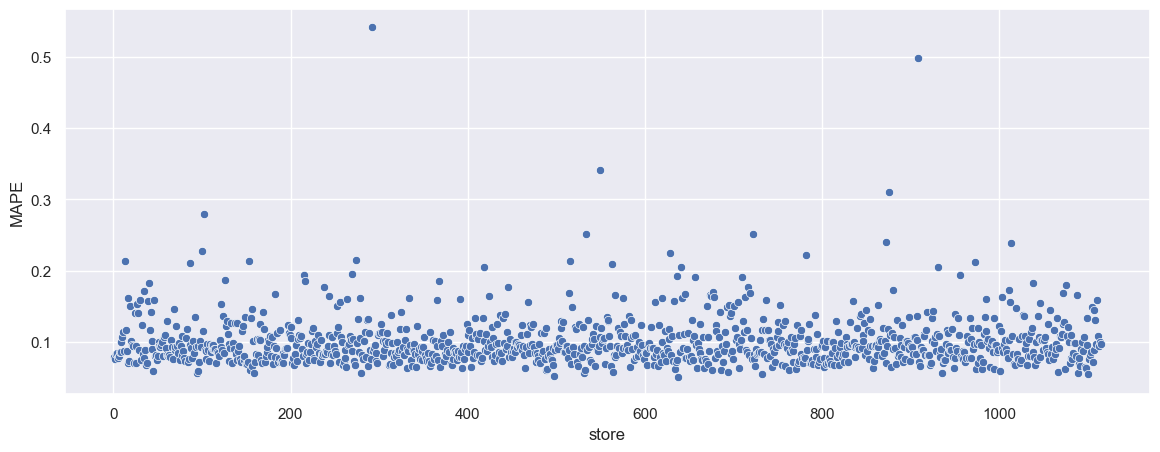

In [434]:
plt.rcParams["figure.figsize"] = (14, 5)
sns.scatterplot( x='store', y='MAPE', data=df_bus_stores );

Notamos acima que a maioria das lojas tem um erro MAPE entre 7 e 15%.

Resumir o pior e melhor cenário pra todas as lojas

In [553]:
df_bus_stores

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,163941.000000,151056.656718,176825.343282,338.234019,0.078591
1,2,174873.703125,161467.334647,188280.071603,390.574410,0.076663
2,3,258354.406250,236784.672584,279924.139916,572.168615,0.083489
3,4,353610.468750,323725.362839,383495.574661,893.244048,0.084514
4,5,163109.421875,150486.365690,175732.478060,352.400539,0.077390
...,...,...,...,...,...,...
1110,1111,185246.921875,155852.821056,214641.022694,694.325466,0.158675
1111,1112,325816.000000,290552.940867,361079.059133,881.313041,0.108230
1112,1113,231586.984375,209603.884638,253570.084112,620.860206,0.094924
1113,1114,763321.687500,686990.291882,839653.083118,2328.869114,0.099999


In [443]:
df_bus_stores_tot = df_bus_stores[['predictions', 'worst_scenario', 'best_scenario']].apply (lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index': 'Scenario', 0: 'Values' } )
df_bus_stores_tot['Values'] = df_bus_stores_tot['Values'].map(lambda x: f"{x/1000000:.0f}M")

In [444]:
df_bus_stores_tot

,Scenario,Values
0,predictions,288M
1,worst_scenario,260M
2,best_scenario,317M


In [557]:
df_bus_stores

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,163941.000000,151056.656718,176825.343282,338.234019,0.078591
1,2,174873.703125,161467.334647,188280.071603,390.574410,0.076663
2,3,258354.406250,236784.672584,279924.139916,572.168615,0.083489
3,4,353610.468750,323725.362839,383495.574661,893.244048,0.084514
4,5,163109.421875,150486.365690,175732.478060,352.400539,0.077390
...,...,...,...,...,...,...
1110,1111,185246.921875,155852.821056,214641.022694,694.325466,0.158675
1111,1112,325816.000000,290552.940867,361079.059133,881.313041,0.108230
1112,1113,231586.984375,209603.884638,253570.084112,620.860206,0.094924
1113,1114,763321.687500,686990.291882,839653.083118,2328.869114,0.099999


In [559]:
#Média de MAE e MAPE em todas as lojas:
df_bus_stores_error_metrics = df_bus_stores[['MAE','MAPE']].apply (lambda x: np.mean( x ), axis=0)

MAE     689.963775
MAPE      0.100734
dtype: float64

## Resultados financeiros para o negócio

As previsões de vendas da Rossmann, eram até antes deste projeto realizadas por meio de planilhas de histórico de venda, através de uma média móvel. 

A taxa de erros desta previsão de vendas de toda a rede ficava na média de 36%, chegando a até 60% nas lojas mais recentes.

Após o primeiro semestre de implementação deste modelo de previsão de vendas com machine learning, a taxa de erro média das previsões em toda a rede passou para 10%.

Essa redução do erro de 26% em média, propiciou que o CFO fosse muito mais assertivo nos empréstimos bancários que fará para a reforma das lojas da rede.

Os empréstimos estimados estavam na casa de €80 milhões antes do projeto. Considerando os juros de 2% ao ano em 2023 na zona do euro, com prazo de 3 ano, seriam gastos aprox. €4,5 milhões em juros.

Após o projeto, a necessidade de emprestimo foi reavaliada em 55 milhões de euros.

Considerando as mesmas condições de emprestimo, serão gastos agora aprox. €3,3 milhões em juros, uma economia de aprox. €1,2 milhões em 3 anos. 

## Machine Learning Performance

Olhar em formato gráfico como as vendas se comportam nas 6 semanas previstas (vendas e erros na linha do tempo, muito interessante!)

In [454]:
df_bus_stores

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,163941.000000,151056.656718,176825.343282,338.234019,0.078591
1,2,174873.703125,161467.334647,188280.071603,390.574410,0.076663
2,3,258354.406250,236784.672584,279924.139916,572.168615,0.083489
3,4,353610.468750,323725.362839,383495.574661,893.244048,0.084514
4,5,163109.421875,150486.365690,175732.478060,352.400539,0.077390
...,...,...,...,...,...,...
1110,1111,185246.921875,155852.821056,214641.022694,694.325466,0.158675
1111,1112,325816.000000,290552.940867,361079.059133,881.313041,0.108230
1112,1113,231586.984375,209603.884638,253570.084112,620.860206,0.094924
1113,1114,763321.687500,686990.291882,839653.083118,2328.869114,0.099999


In [467]:
df_bus_raw['error'] = df_bus_raw['sales'] - df_bus_raw['predictions']
df_bus_raw['error_rate'] = df_bus_raw['predictions'] / df_bus_raw['sales']

In [489]:
df_bus_raw.head(5)

,school_holiday,assortment,compet_distance,promo_today,promo_ext,promo_ext_init_year,promo_ext_today,promo_ext_active_weeks,store_type_a,store_type_b,day_of_week_sin,compet_init_month_cos,promo_ext_init_week_sin,store,compet_init_year,day_of_week_cos,compet_init_month_sin,promo_ext_init_week_cos,month_sale_cos,date,sales,predictions,error,error_rate
0,1,1,0.006251,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,1,0.939130,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,5263.0,4964.357422,298.642578,0.943256
1,1,1,0.002750,1,1,0.166667,1,0.891374,1,0,-0.974928,8.660254e-01,1.000000,2,0.930435,-0.222521,-5.000000e-01,6.123234e-17,-0.866025,2015-07-31,6064.0,4918.350098,1145.649902,0.811074
2,1,1,0.070557,1,1,0.333333,1,0.722045,1,0,-0.974928,1.000000e+00,0.992709,3,0.921739,-0.222521,-2.449294e-16,-1.205367e-01,-0.866025,2015-07-31,8314.0,7571.616211,742.383789,0.910707
3,1,3,0.003000,1,0,1.000000,0,0.000000,0,0,-0.974928,-1.836970e-16,-0.568065,4,0.947826,-0.222521,-1.000000e+00,-8.229839e-01,-0.866025,2015-07-31,13995.0,10651.156250,3343.843750,0.761069
4,1,1,0.149465,1,0,1.000000,0,0.000000,1,0,-0.974928,-5.000000e-01,-0.568065,5,1.000000,-0.222521,8.660254e-01,-8.229839e-01,-0.866025,2015-07-31,4822.0,4828.720703,-6.720703,1.001394


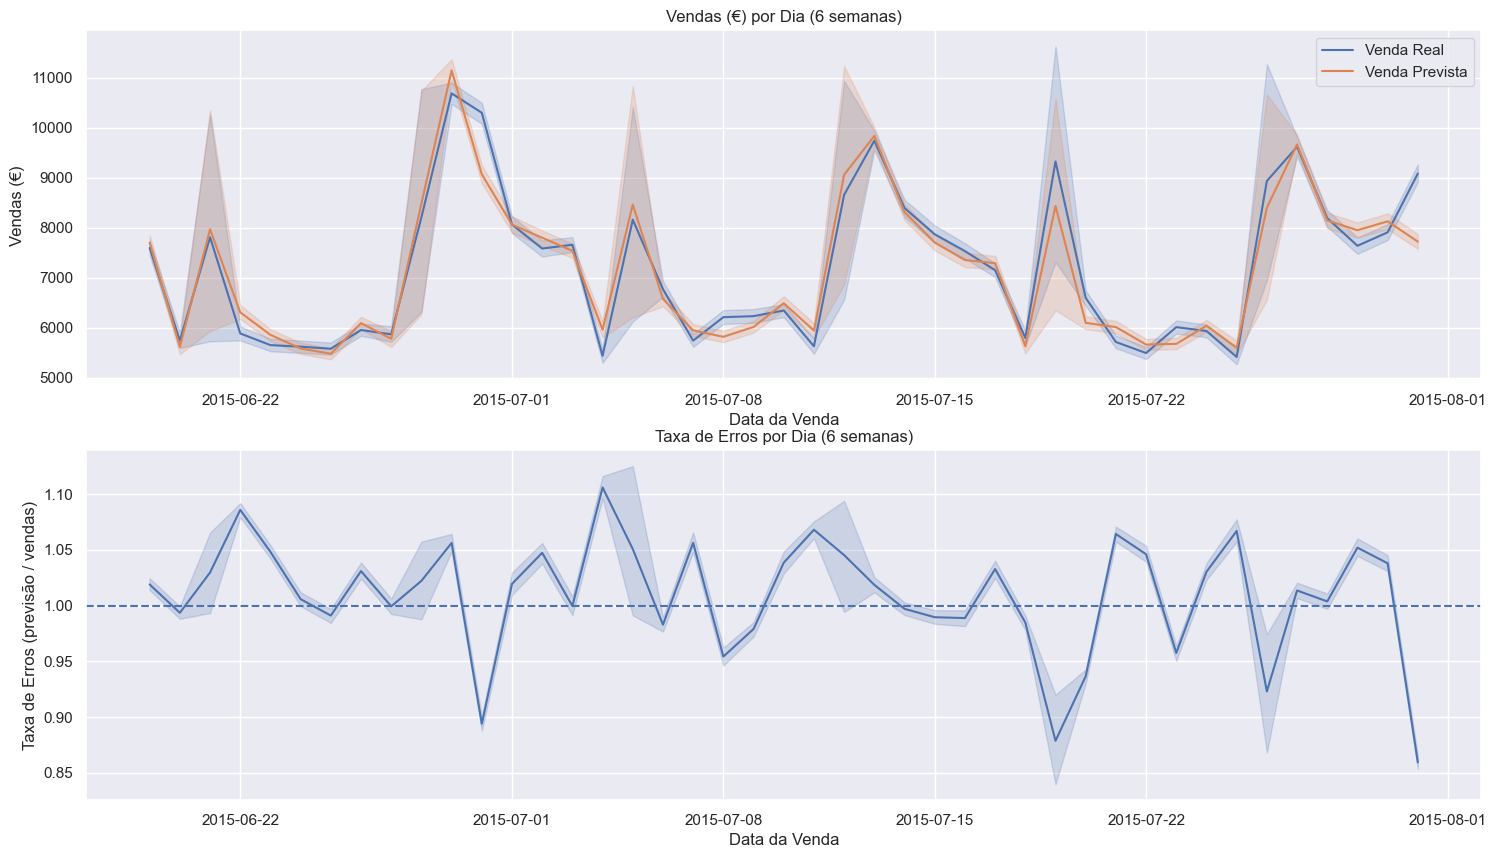

In [567]:
plt.rcParams["figure.figsize"] = (18,10)

plt.subplot( 2,1,1 )
plt_sales_pred = sns.lineplot( x='date', y='sales', data=df_bus_raw, label='Venda Real' );
plt_sales_pred = sns.lineplot( x='date', y='predictions', data=df_bus_raw, label='Venda Prevista' );
plt_sales_pred.set_title('Vendas (€) por Dia (6 semanas)');
plt_sales_pred.set_ylabel('Vendas (€)');
plt_sales_pred.set_xlabel('Data da Venda');

plt.subplot( 2,1,2)
plt.rcParams["figure.figsize"] = (16, 4)
plt_error_rate = sns.lineplot( x='date', y='error_rate', data=df_bus_raw);
plt_error_rate.axhline( 1, linestyle='--');
plt_error_rate.set_title('Taxa de Erros por Dia (6 semanas)');
plt_error_rate.set_ylabel('Taxa de Erros (previsão / vendas)');
plt_error_rate.set_xlabel('Data da Venda');

Gráfico superior:
 - Em laranja, temos a variancia, onde a área pintada representa a variação de previsões.
 - A predição está bem próxima das vendas ao longo do tempo de modo geral, mas vemos alguns pontos onde há variação maior, principalmente nos picos de vendas.
 
Gráfico inferior:
 - A taxa de erros por dia é calculada pela Venda Rela / Venda Prevista.
 - Quando a taxa é = 1, a previsão foi perfeita. Quando acima, a predição foi > que a venda, e o modelo superestimou as vendas. Abaixo de 1, subestimou.

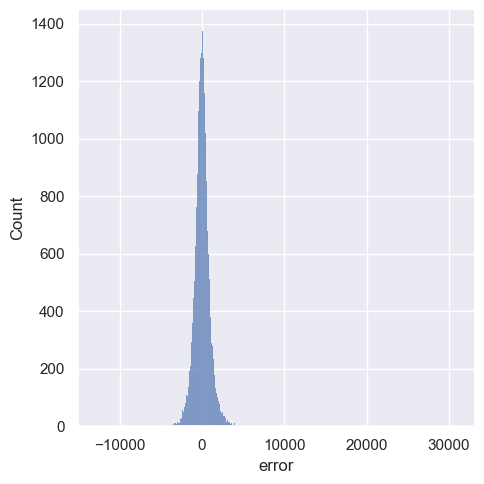

In [547]:
sns.displot( data=df_bus_raw, x='error');

A distribuição do erro acima está parecida com uma normal.
- Isso é bem positivo, pois isto é usado para análise do resíduo: aborda quais pontos fracos tem o modelo, para que possamos trabalhar nas melhorias dele.

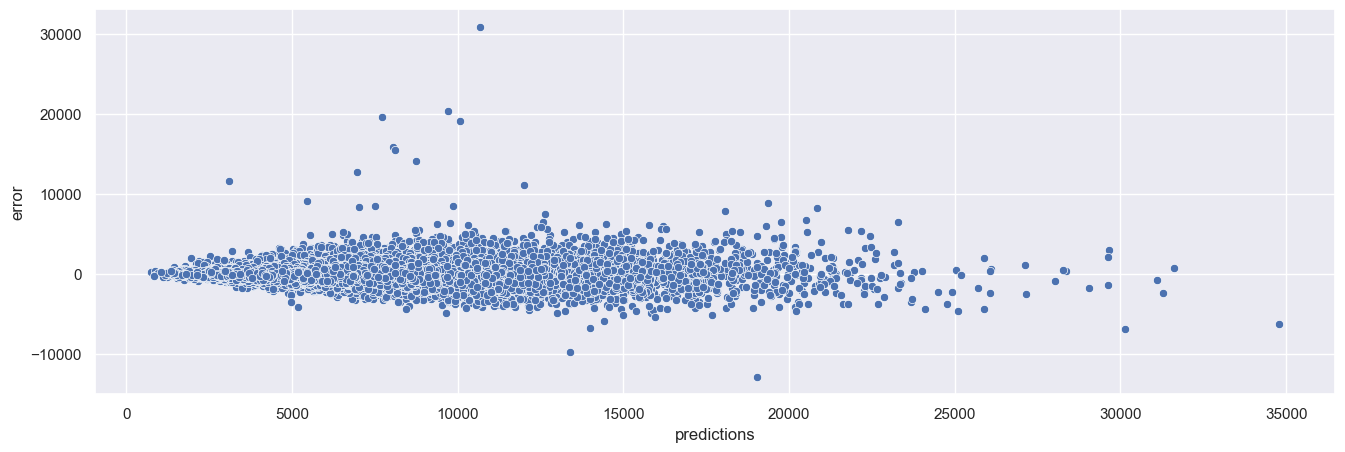

In [551]:
plt.rcParams["figure.figsize"] = (16,5)
ns.scatterplot( data=df_bus_raw, x='predictions', y='error' );

O gráfico de resíduo acima mostra que previsões entre €5k e €10k vendas, tem erros um pouco maiores que as demais faixas. 
- Sendo esta diferença sutil, está muito bom, visto que o gráfico precisa estar em formato de um tubo horizontal, como está o nosso. Alguns outliers são normal, como neste nosso cenário.

# Melhorias para próximos ciclos

- Melhorar a performance do modelo:
- Rodar modelos simples após feature selection, visando constatar já aqui o aumento nas métricas de performance.
  - Aumentar o a quantidade de combinações de features no random search.
- Splitar treino e teste antes do início do projeto, visando não enviesar minha análise como DS na EDA. Antes de testar o modelo final contra dados de teste, fazer então as mesmas transformações feitas nos dados de treino/validação.
- Implementar pipelines para preprocessing, ML e cross validation.